In [1]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [2]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm

In [3]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 10

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 20



# The number of solutions that we will have in the solver after the first iteration
k_k = 10

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [4]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, tasks = fm.initialize_solver(data, n, m, duration)

model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !

Solving the model...
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 2202144
Le max de list_obj est 2425808
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x000002D2E9BDF1C0>, <docplex.cp.solution.CpoSolveResult object at 0x000002D2E9BDF0C0>, <docplex.cp.solution.CpoSolveResult object at 0x000002D2E9BDF6C0>, <docplex.cp.solution.CpoSolveResult object at 0x000002D2E9BD

In [5]:
####################################################################
#### NOUVELLES SOLUTIONS ET NOUVEAUX CLUSTERING A CHAQUE ITERATION
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max) and (it < it_max) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, tasks = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # --------- Add the constraints considering the clustering
    if it > 1:
        model, variables = solver.create_constraints(model, n, m, list_min_obj_global[it-1], T_machine)
    else :
        model, variables = solver.create_constraints(model, n, m, optimalval, T_machine)
    
    #------------------ Layers creation 
    # layers = cl.create_layers(list_equal, matrix)
    layers = cl.create_layers_fixed(list_layers)
    print(len(layers))
    # print(len(layers[i]) for i in range (len(layers)))
        #------------------ Définition du nombre de clusters par layer (liste des nb de clusters par layer)
    nb_clusters = fm.choose_best_clusters(layers)

    default_value_rayon = 5 

    for l in range(len(layers)):
        data = layers[l]
        k = nb_clusters[l]

        print("-------------- Layer", l, "-----------------")
        print("Number of clusters :", k)
        print("Number of solutions :", len(data))

        if l > 0:
            #------------------ If there is only one solution in the layer, we add a constraint to the model
            if(len(data)==0):
                continue
            elif (len(data) == 1):
                solver.add_constraint(model, fm.manhattan_distance(data[0], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > default_value_rayon + l)
                continue
            else :
            #------------------ Get the average of each cluster
                k, avg, labels = fm.average_computation(data, k)

            #------------------ Get the solutions which is the closest to the average of each cluster
                the_ones = fm.solution_average(k, data, labels, avg)
                
            #------------------ Ajout de contraintes, les solutions doivent etre distantes des centres de clusters, en chaque layer , d'une distance supérieure au rayon du cluster + l
                #------------------ Liste des solutions des clusters de la layer l

                for i in range(k):
                    sol_cluster=[]
                    for j in range(len(data)):
                        if labels[j]==i:
                            sol_cluster.append(data[j])
                #------------------ Ajout des contraintes
                    solver.add_constraint(model, fm.manhattan_distance(the_ones[i],[ model.start_of(variables[i//m][i%m]) for i in range(n*m)]) >  fm.rayon_cluster(the_ones[i], sol_cluster) + l)
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, variables)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)


#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max)
    fm.stopCondition(it, it_max, tps, tps_max)

    it += 1


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Clustering ...
5
-------------- Layer 0 -----------------
Number of clusters : 3
Number of solutions : 4
-------------- Layer 1 -----------------
Number of clusters : 2
Number of solutions : 3
-------------- Layer 2 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 3 -----------------
Number of clusters : 1
Number of solutions : 1
-------------- Layer 4 -----------------
Number of clusters : 1
Number of solutions : 1

Solving the model...
The number of solutions generated is : 10
Objective function : [2202144, 2204928]
Model solved !

Classing solutions...
Le min de list_obj est 2202144
Le max de list_obj est 2432064
Solutions classed !

Creating preferences...
Preferences created

[2202144, 2204928, 2207712, 2357912, 2213672, 2219640, 2224974, 2229552, 2234134, 2238720, 2243310, 2247904, 2252502, 2257104, 2261710, 2266320, 2270934, 2275552, 2280174, 2284800, 2289430]


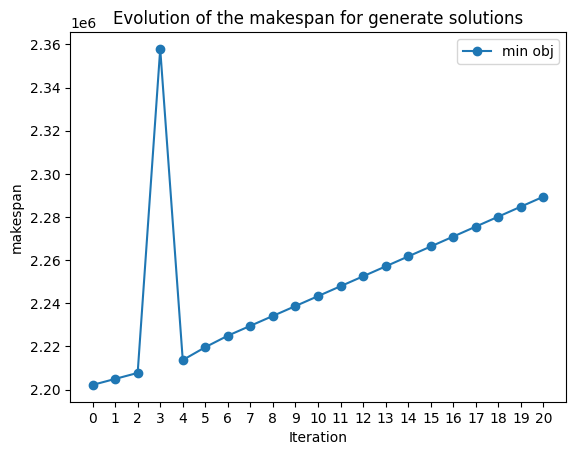

In [6]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144, 2202144]


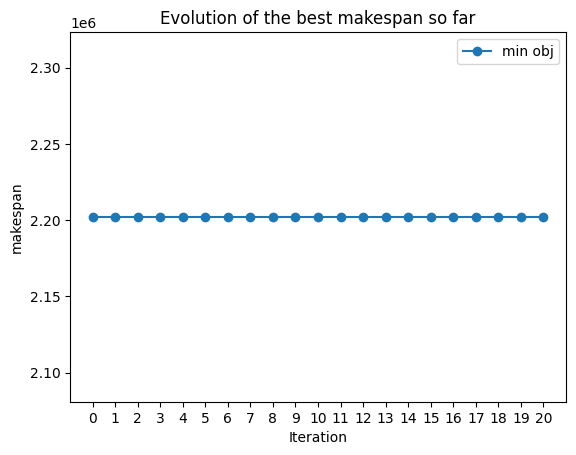

In [7]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

210


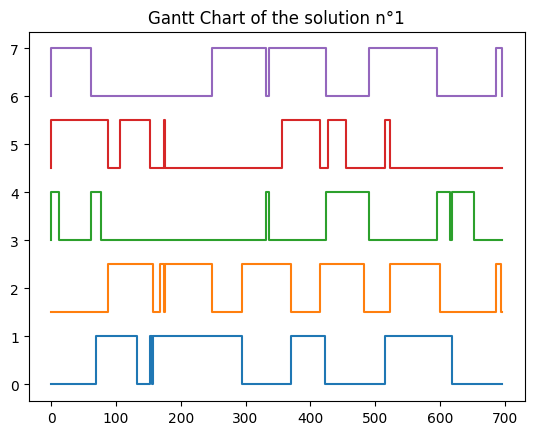

Makespan of the solution n°1 : 696
Regularity of the solution n°1 : 3164
Objective function of the solution n°1 : 2202144


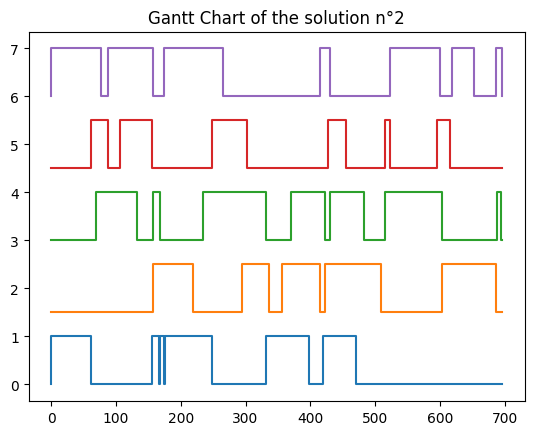

Makespan of the solution n°2 : 696
Regularity of the solution n°2 : 3168
Objective function of the solution n°2 : 2204928


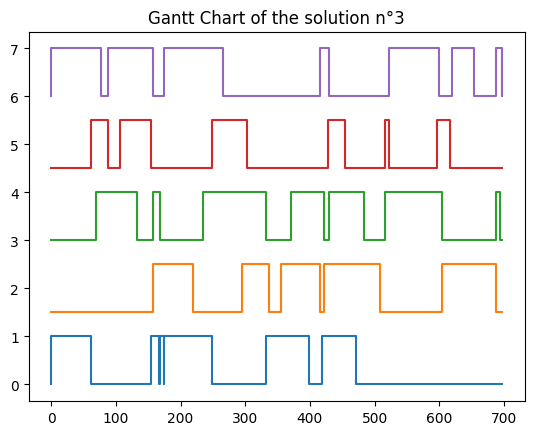

Makespan of the solution n°3 : 697
Regularity of the solution n°3 : 3166
Objective function of the solution n°3 : 2206702


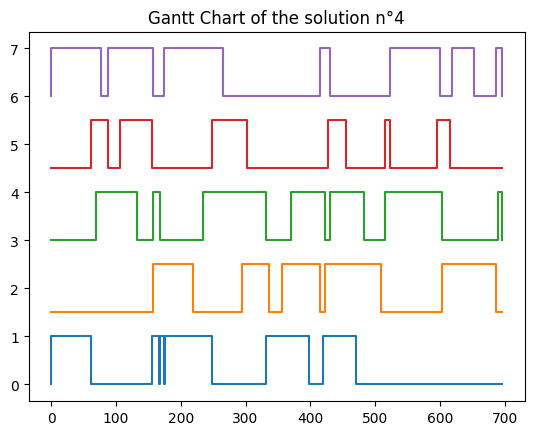

Makespan of the solution n°4 : 696
Regularity of the solution n°4 : 3172
Objective function of the solution n°4 : 2207712


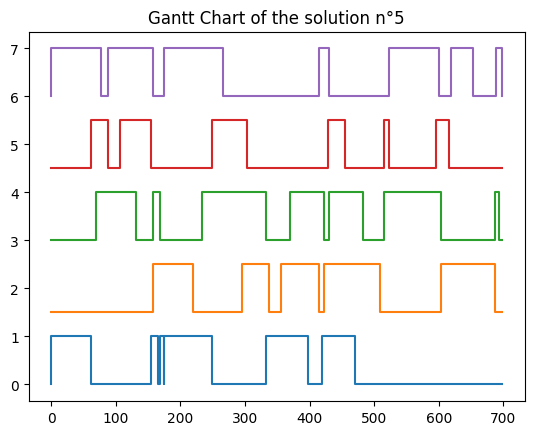

Makespan of the solution n°5 : 698
Regularity of the solution n°5 : 3168
Objective function of the solution n°5 : 2211264


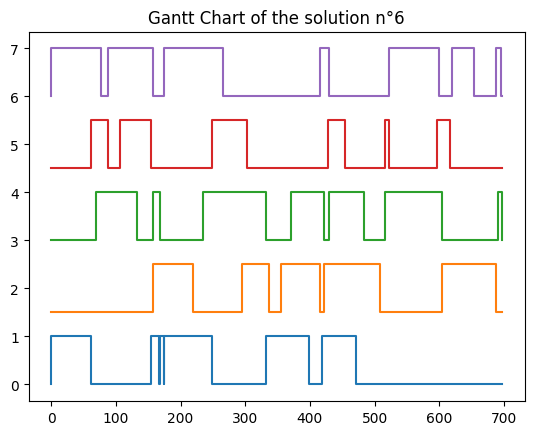

Makespan of the solution n°6 : 697
Regularity of the solution n°6 : 3176
Objective function of the solution n°6 : 2213672


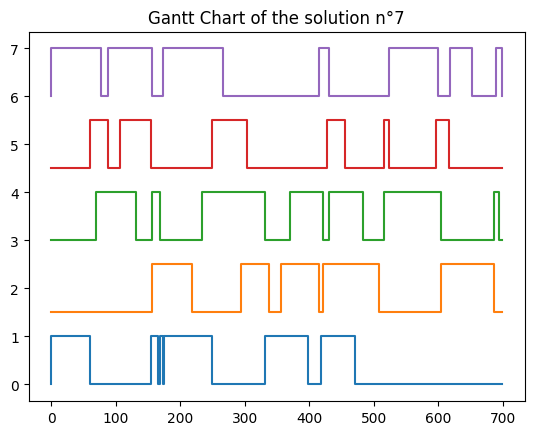

Makespan of the solution n°7 : 699
Regularity of the solution n°7 : 3170
Objective function of the solution n°7 : 2215830


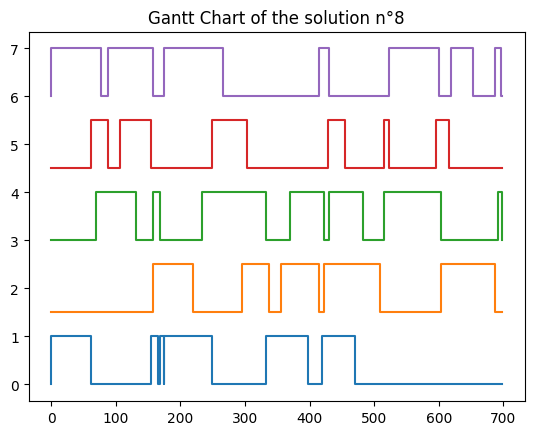

Makespan of the solution n°8 : 698
Regularity of the solution n°8 : 3180
Objective function of the solution n°8 : 2219640


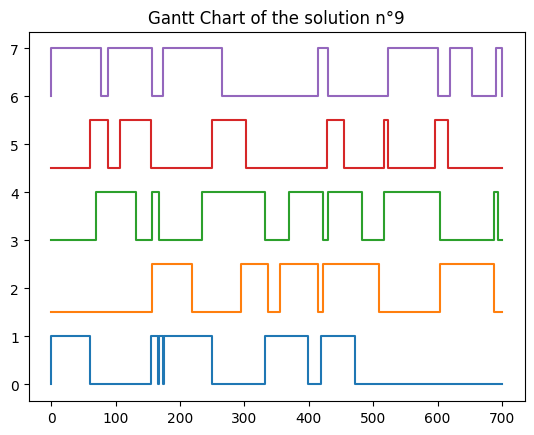

Makespan of the solution n°9 : 700
Regularity of the solution n°9 : 3172
Objective function of the solution n°9 : 2220400


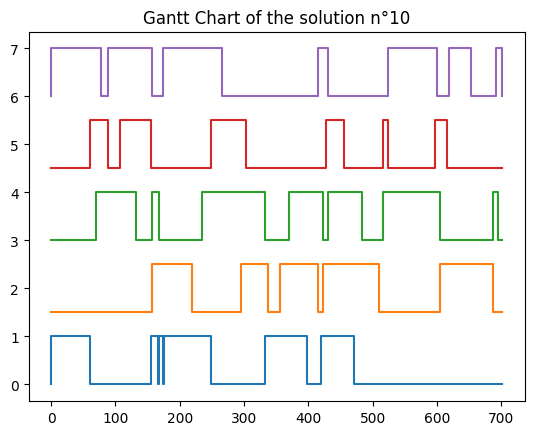

Makespan of the solution n°10 : 701
Regularity of the solution n°10 : 3174
Objective function of the solution n°10 : 2224974


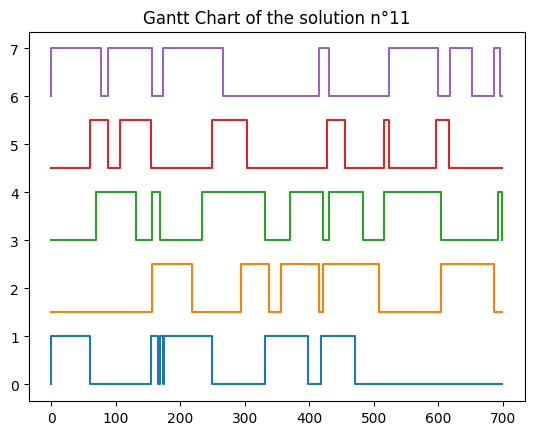

Makespan of the solution n°11 : 699
Regularity of the solution n°11 : 3184
Objective function of the solution n°11 : 2225616


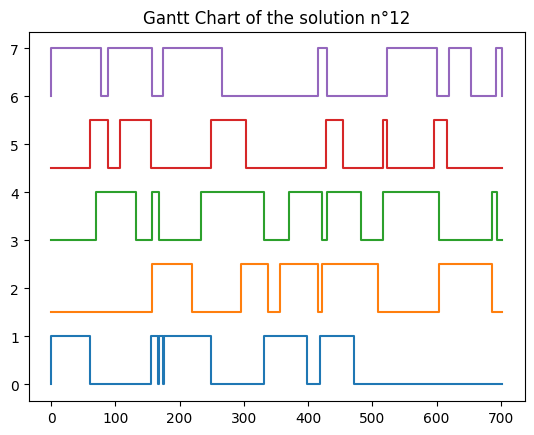

Makespan of the solution n°12 : 702
Regularity of the solution n°12 : 3176
Objective function of the solution n°12 : 2229552


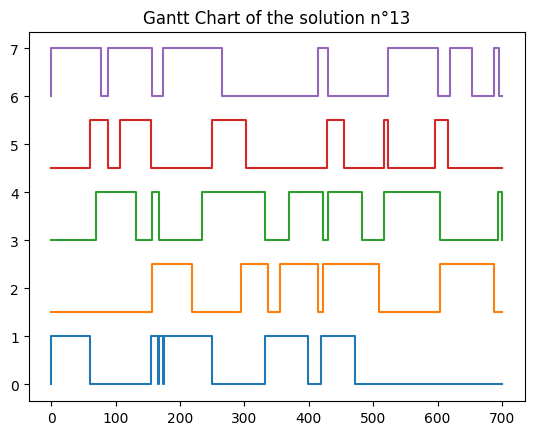

Makespan of the solution n°13 : 700
Regularity of the solution n°13 : 3188
Objective function of the solution n°13 : 2231600


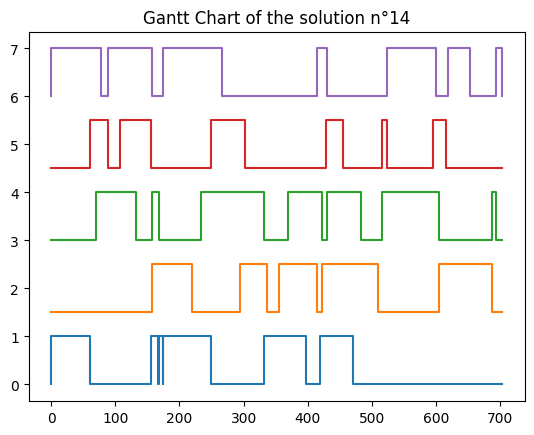

Makespan of the solution n°14 : 703
Regularity of the solution n°14 : 3178
Objective function of the solution n°14 : 2234134


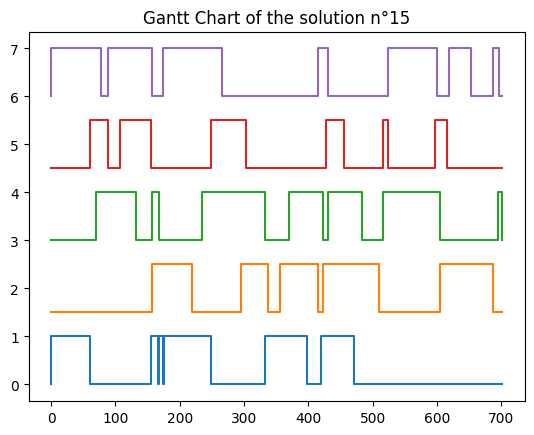

Makespan of the solution n°15 : 701
Regularity of the solution n°15 : 3192
Objective function of the solution n°15 : 2237592


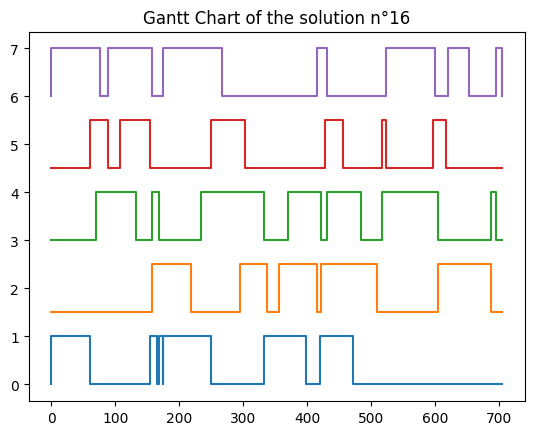

Makespan of the solution n°16 : 704
Regularity of the solution n°16 : 3180
Objective function of the solution n°16 : 2238720


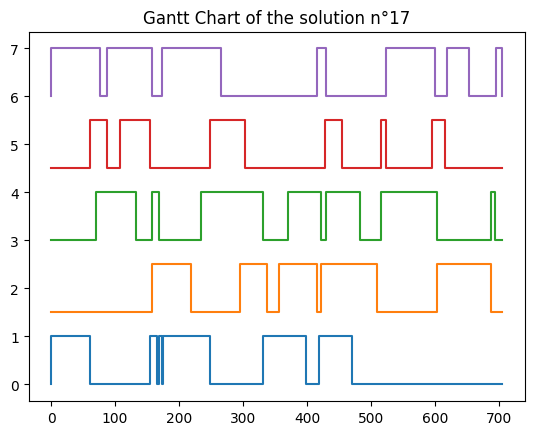

Makespan of the solution n°17 : 705
Regularity of the solution n°17 : 3182
Objective function of the solution n°17 : 2243310


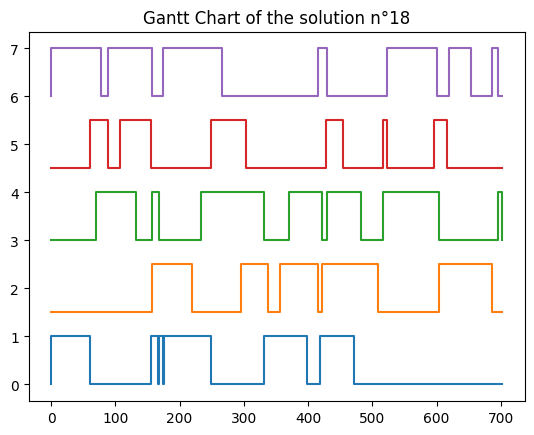

Makespan of the solution n°18 : 702
Regularity of the solution n°18 : 3196
Objective function of the solution n°18 : 2243592


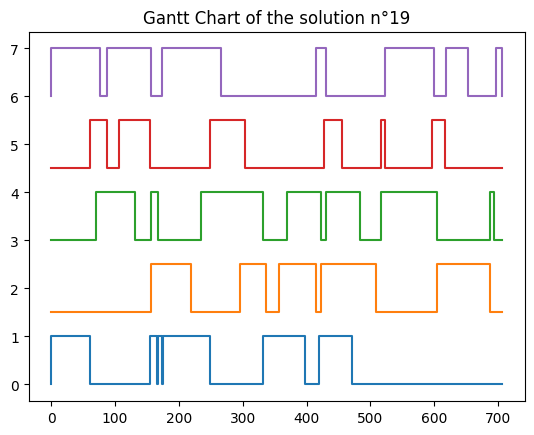

Makespan of the solution n°19 : 706
Regularity of the solution n°19 : 3184
Objective function of the solution n°19 : 2247904


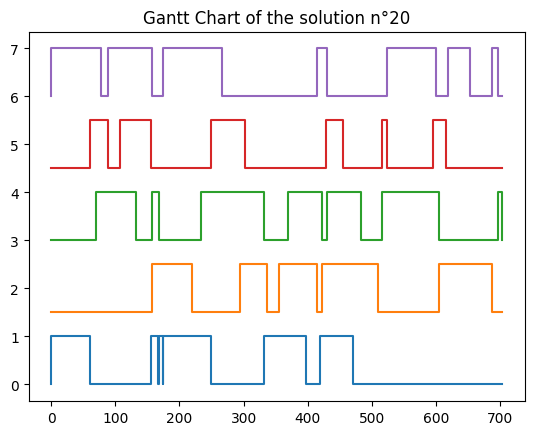

Makespan of the solution n°20 : 703
Regularity of the solution n°20 : 3200
Objective function of the solution n°20 : 2249600


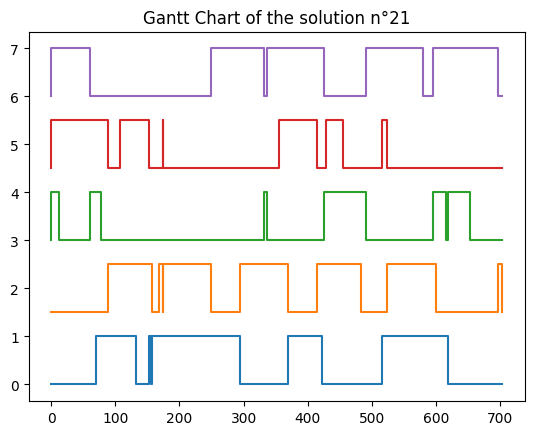

Makespan of the solution n°21 : 703
Regularity of the solution n°21 : 3200
Objective function of the solution n°21 : 2249600


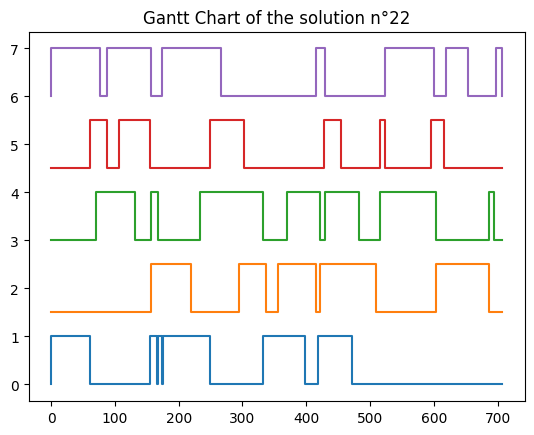

Makespan of the solution n°22 : 707
Regularity of the solution n°22 : 3186
Objective function of the solution n°22 : 2252502


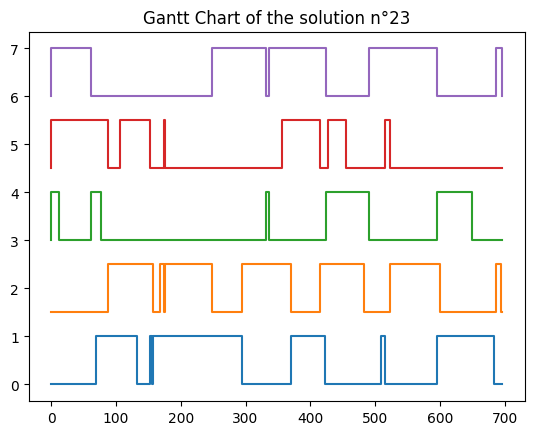

Makespan of the solution n°23 : 696
Regularity of the solution n°23 : 3238
Objective function of the solution n°23 : 2253648


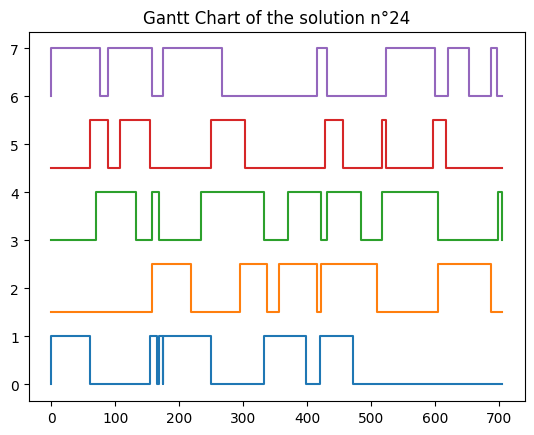

Makespan of the solution n°24 : 704
Regularity of the solution n°24 : 3204
Objective function of the solution n°24 : 2255616


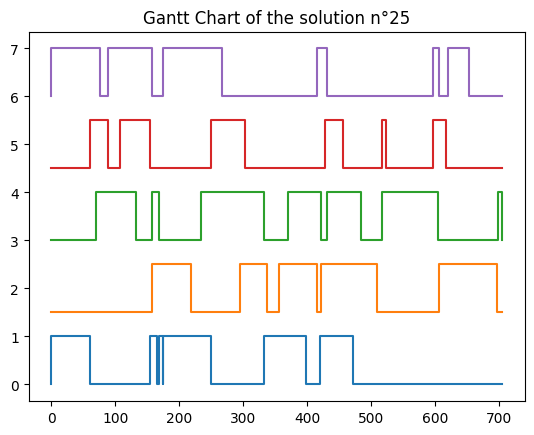

Makespan of the solution n°25 : 704
Regularity of the solution n°25 : 3204
Objective function of the solution n°25 : 2255616


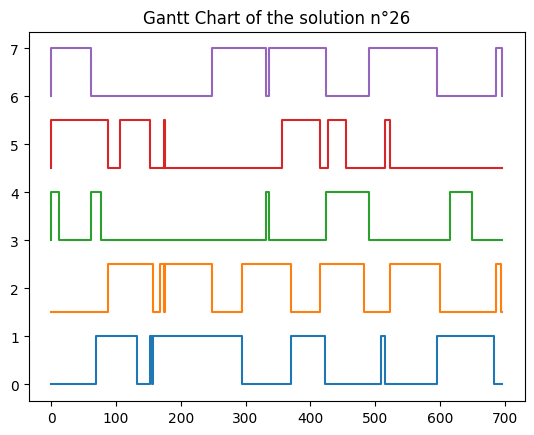

Makespan of the solution n°26 : 696
Regularity of the solution n°26 : 3242
Objective function of the solution n°26 : 2256432


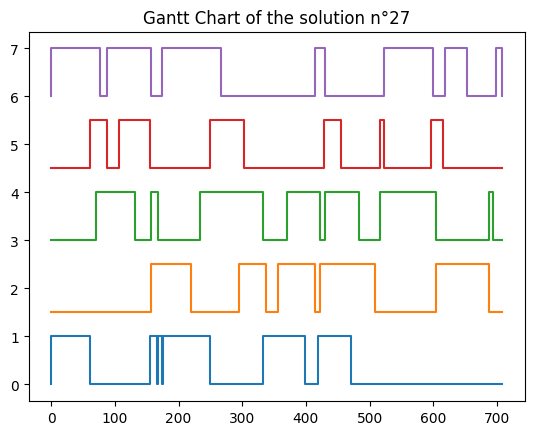

Makespan of the solution n°27 : 708
Regularity of the solution n°27 : 3188
Objective function of the solution n°27 : 2257104


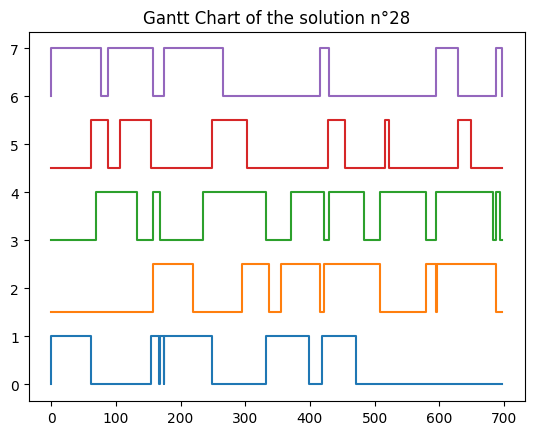

Makespan of the solution n°28 : 697
Regularity of the solution n°28 : 3240
Objective function of the solution n°28 : 2258280


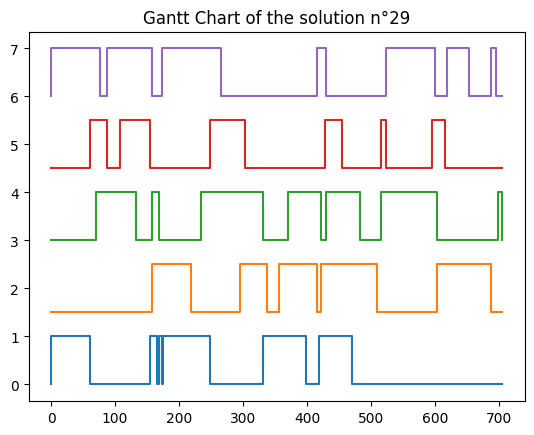

Makespan of the solution n°29 : 705
Regularity of the solution n°29 : 3208
Objective function of the solution n°29 : 2261640


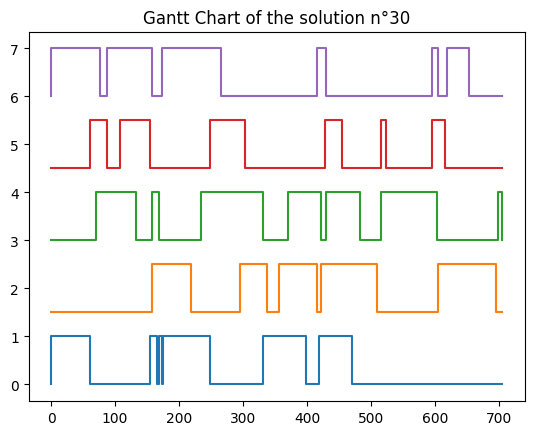

Makespan of the solution n°30 : 705
Regularity of the solution n°30 : 3208
Objective function of the solution n°30 : 2261640


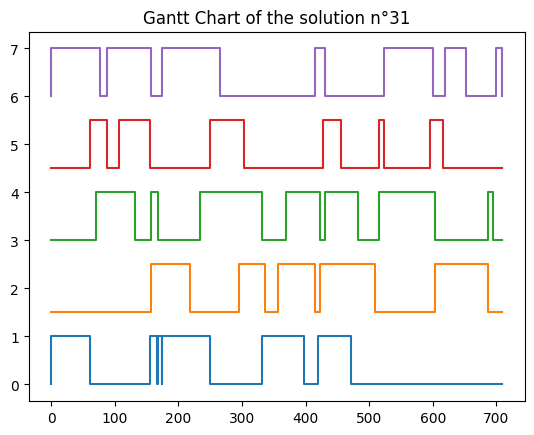

Makespan of the solution n°31 : 709
Regularity of the solution n°31 : 3190
Objective function of the solution n°31 : 2261710


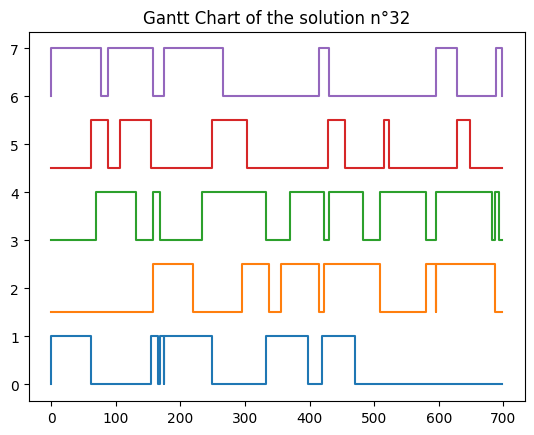

Makespan of the solution n°32 : 698
Regularity of the solution n°32 : 3242
Objective function of the solution n°32 : 2262916


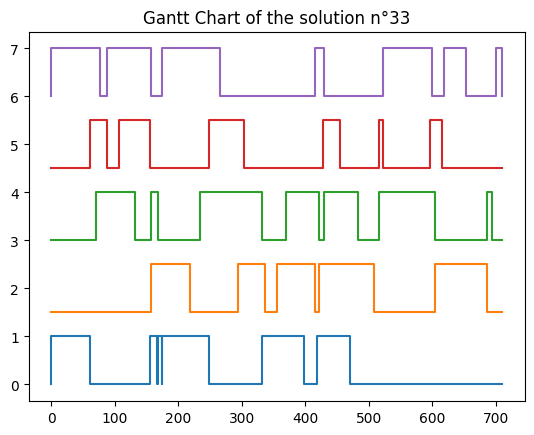

Makespan of the solution n°33 : 710
Regularity of the solution n°33 : 3192
Objective function of the solution n°33 : 2266320


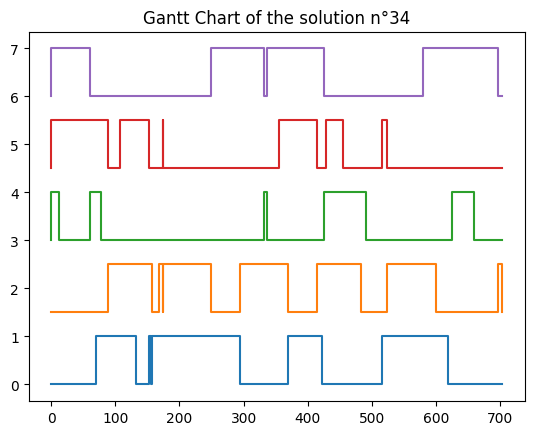

Makespan of the solution n°34 : 703
Regularity of the solution n°34 : 3224
Objective function of the solution n°34 : 2266472


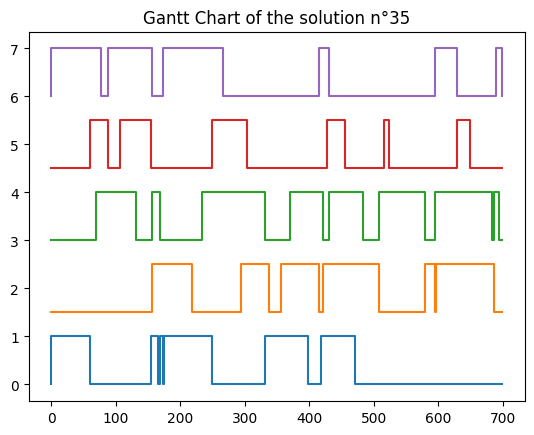

Makespan of the solution n°35 : 699
Regularity of the solution n°35 : 3244
Objective function of the solution n°35 : 2267556


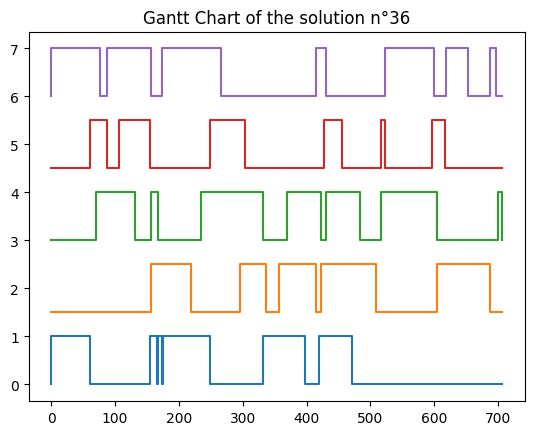

Makespan of the solution n°36 : 706
Regularity of the solution n°36 : 3212
Objective function of the solution n°36 : 2267672


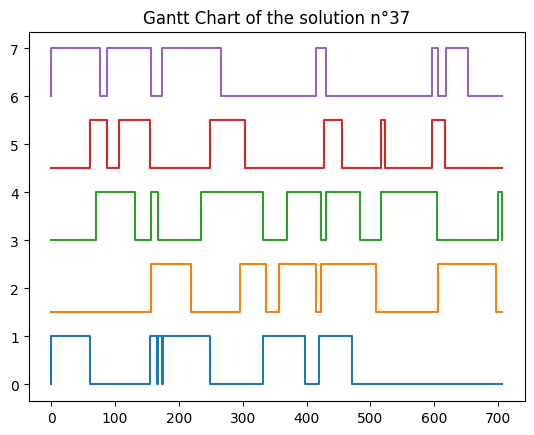

Makespan of the solution n°37 : 706
Regularity of the solution n°37 : 3212
Objective function of the solution n°37 : 2267672


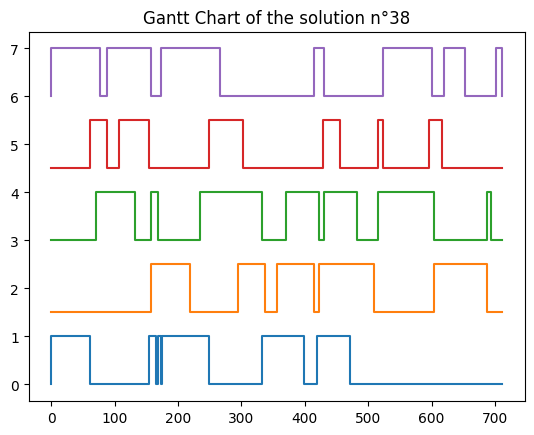

Makespan of the solution n°38 : 711
Regularity of the solution n°38 : 3194
Objective function of the solution n°38 : 2270934


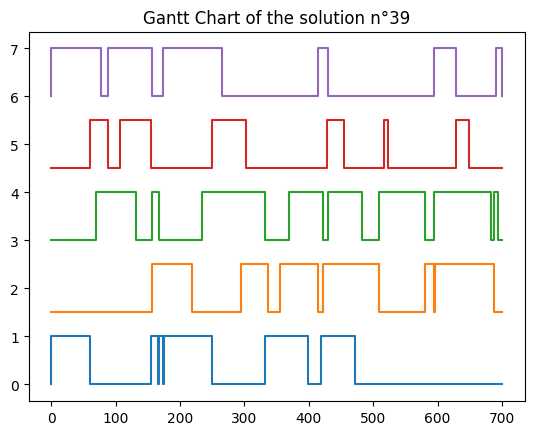

Makespan of the solution n°39 : 700
Regularity of the solution n°39 : 3246
Objective function of the solution n°39 : 2272200


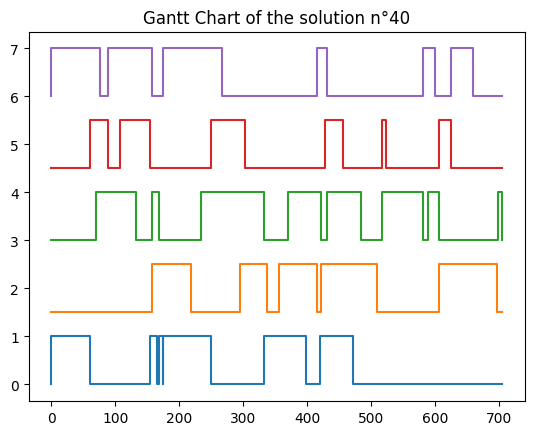

Makespan of the solution n°40 : 704
Regularity of the solution n°40 : 3228
Objective function of the solution n°40 : 2272512


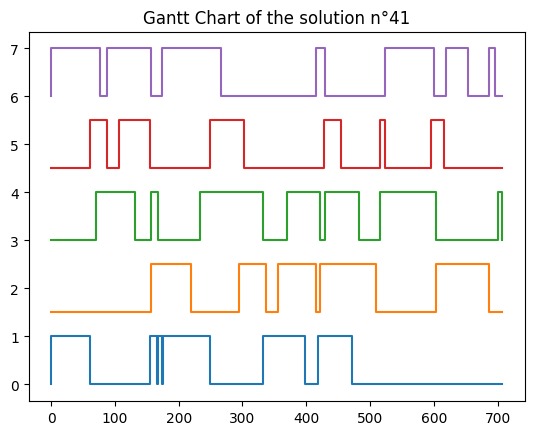

Makespan of the solution n°41 : 707
Regularity of the solution n°41 : 3216
Objective function of the solution n°41 : 2273712


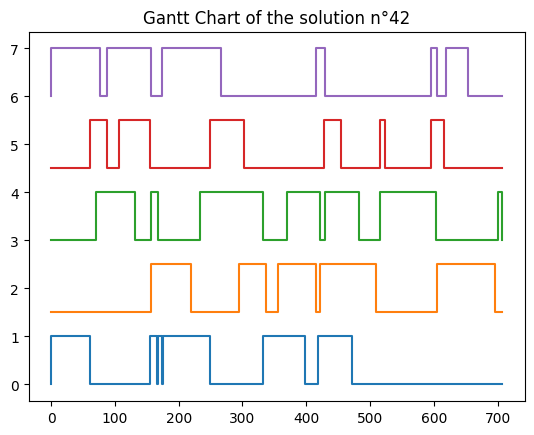

Makespan of the solution n°42 : 707
Regularity of the solution n°42 : 3216
Objective function of the solution n°42 : 2273712


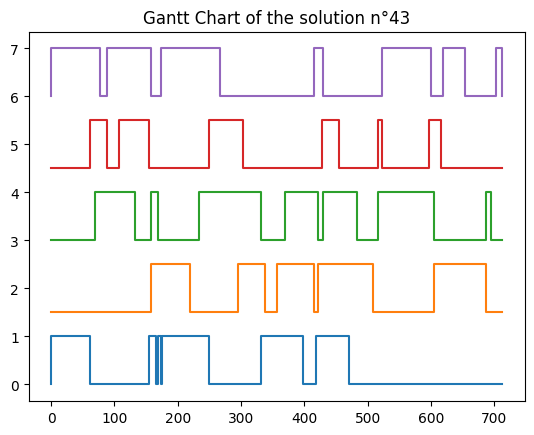

Makespan of the solution n°43 : 712
Regularity of the solution n°43 : 3196
Objective function of the solution n°43 : 2275552


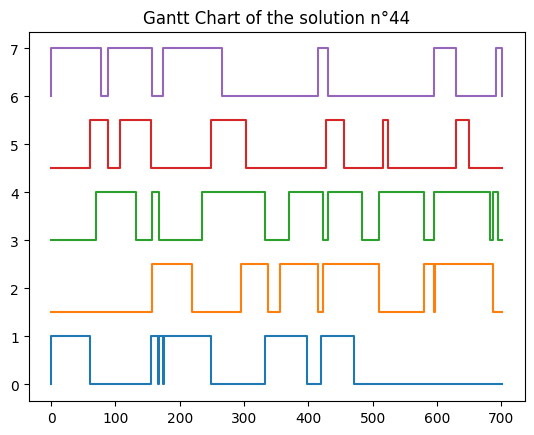

Makespan of the solution n°44 : 701
Regularity of the solution n°44 : 3248
Objective function of the solution n°44 : 2276848


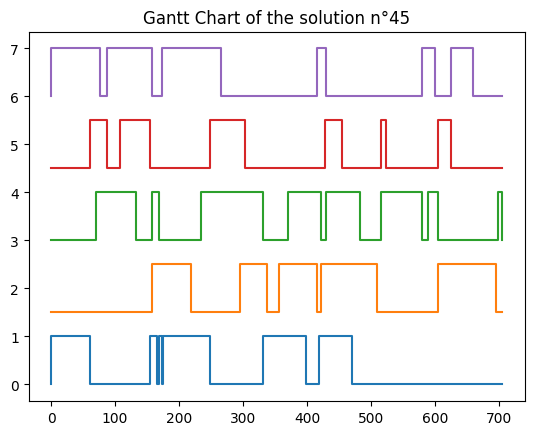

Makespan of the solution n°45 : 705
Regularity of the solution n°45 : 3232
Objective function of the solution n°45 : 2278560


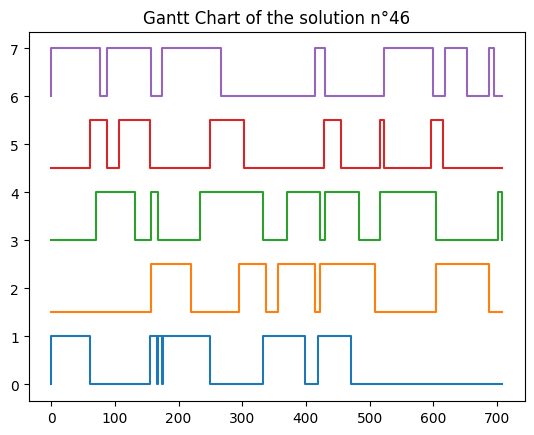

Makespan of the solution n°46 : 708
Regularity of the solution n°46 : 3220
Objective function of the solution n°46 : 2279760


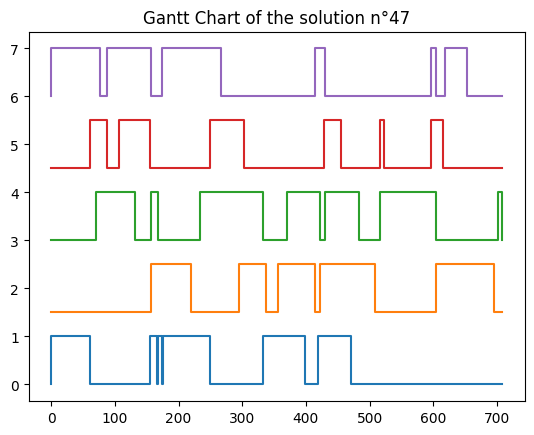

Makespan of the solution n°47 : 708
Regularity of the solution n°47 : 3220
Objective function of the solution n°47 : 2279760


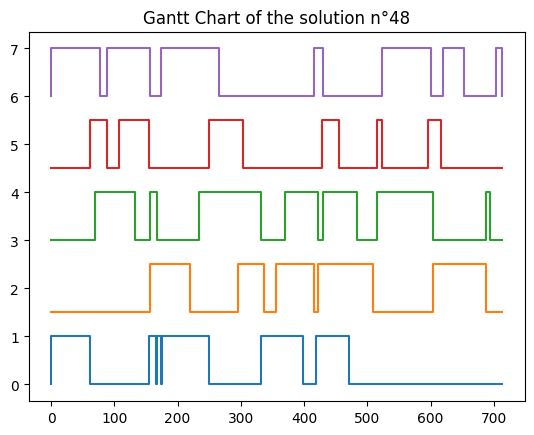

Makespan of the solution n°48 : 713
Regularity of the solution n°48 : 3198
Objective function of the solution n°48 : 2280174


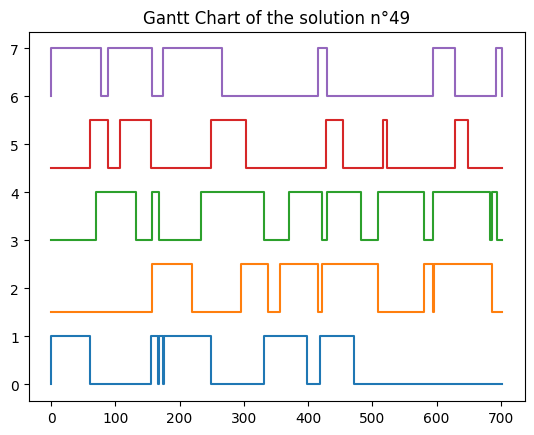

Makespan of the solution n°49 : 702
Regularity of the solution n°49 : 3250
Objective function of the solution n°49 : 2281500


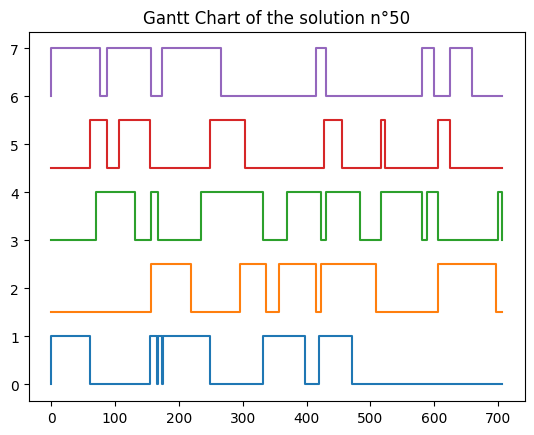

Makespan of the solution n°50 : 706
Regularity of the solution n°50 : 3236
Objective function of the solution n°50 : 2284616


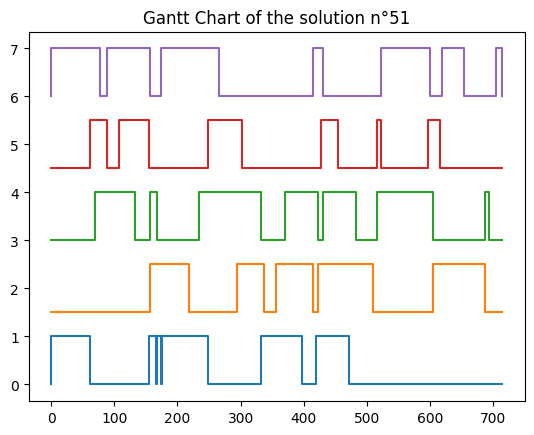

Makespan of the solution n°51 : 714
Regularity of the solution n°51 : 3200
Objective function of the solution n°51 : 2284800


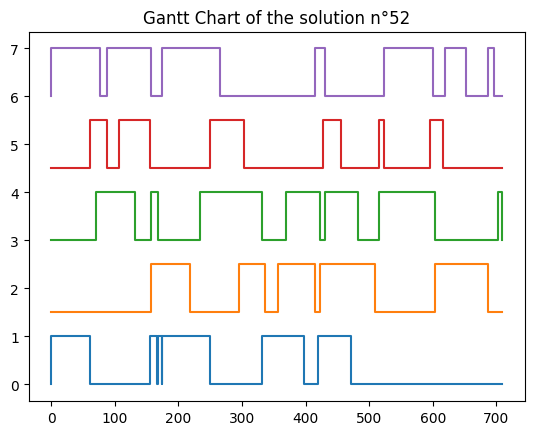

Makespan of the solution n°52 : 709
Regularity of the solution n°52 : 3224
Objective function of the solution n°52 : 2285816


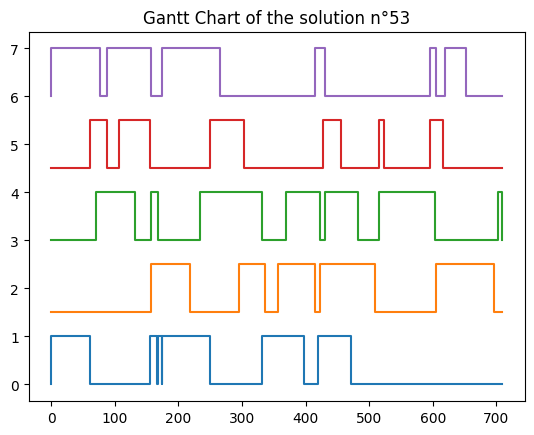

Makespan of the solution n°53 : 709
Regularity of the solution n°53 : 3224
Objective function of the solution n°53 : 2285816


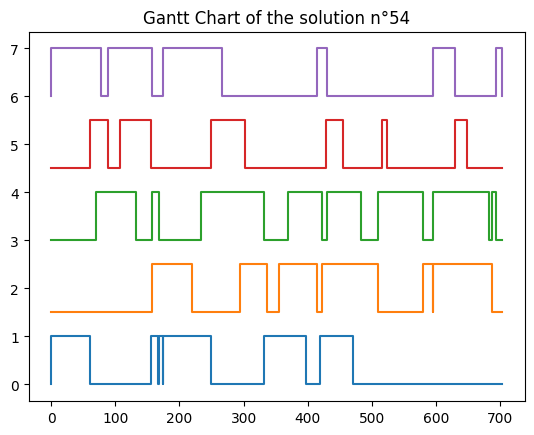

Makespan of the solution n°54 : 703
Regularity of the solution n°54 : 3252
Objective function of the solution n°54 : 2286156


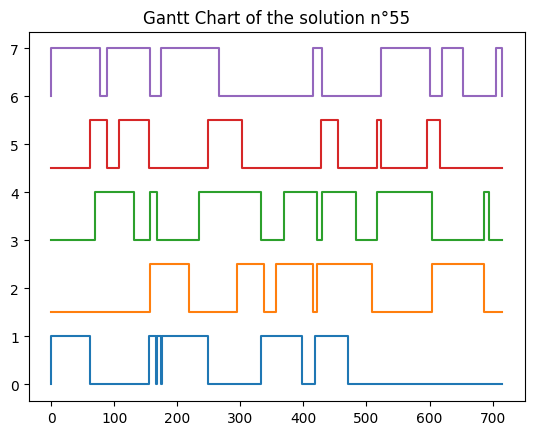

Makespan of the solution n°55 : 715
Regularity of the solution n°55 : 3202
Objective function of the solution n°55 : 2289430


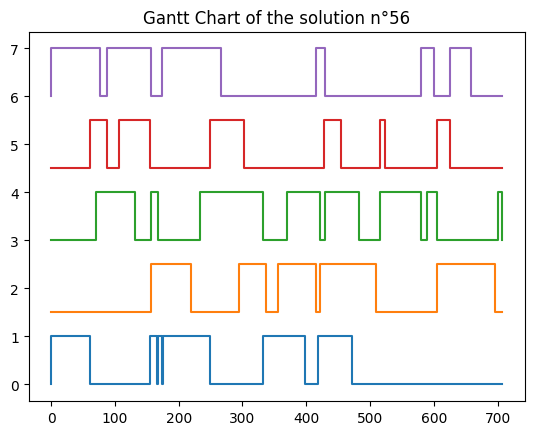

Makespan of the solution n°56 : 707
Regularity of the solution n°56 : 3240
Objective function of the solution n°56 : 2290680


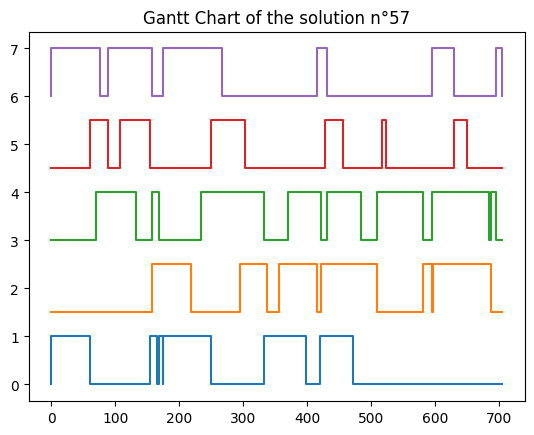

Makespan of the solution n°57 : 704
Regularity of the solution n°57 : 3254
Objective function of the solution n°57 : 2290816


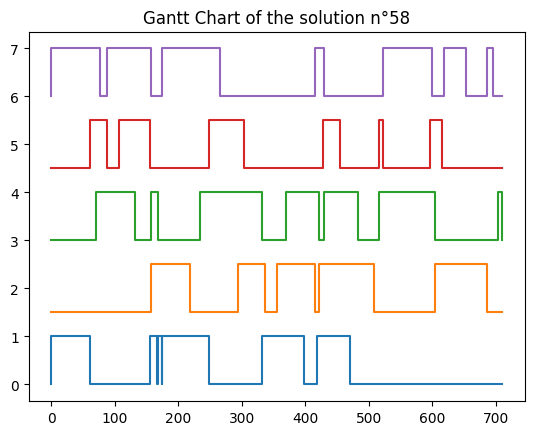

Makespan of the solution n°58 : 710
Regularity of the solution n°58 : 3228
Objective function of the solution n°58 : 2291880


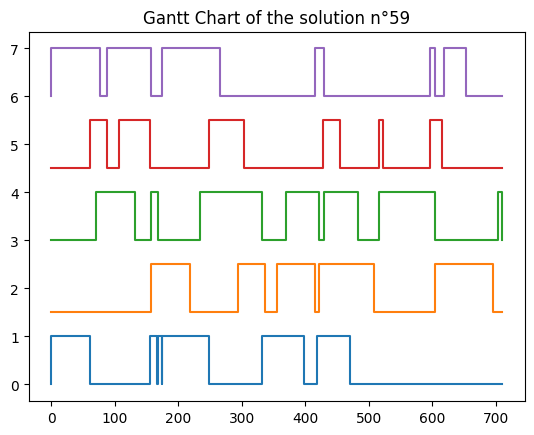

Makespan of the solution n°59 : 710
Regularity of the solution n°59 : 3228
Objective function of the solution n°59 : 2291880


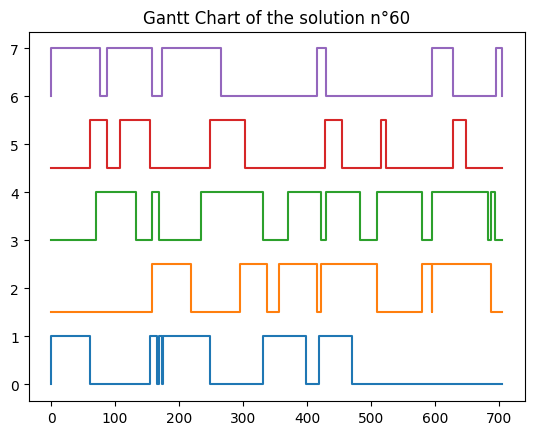

Makespan of the solution n°60 : 705
Regularity of the solution n°60 : 3256
Objective function of the solution n°60 : 2295480


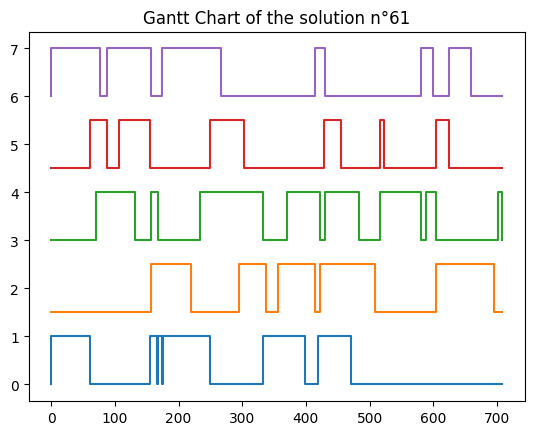

Makespan of the solution n°61 : 708
Regularity of the solution n°61 : 3244
Objective function of the solution n°61 : 2296752


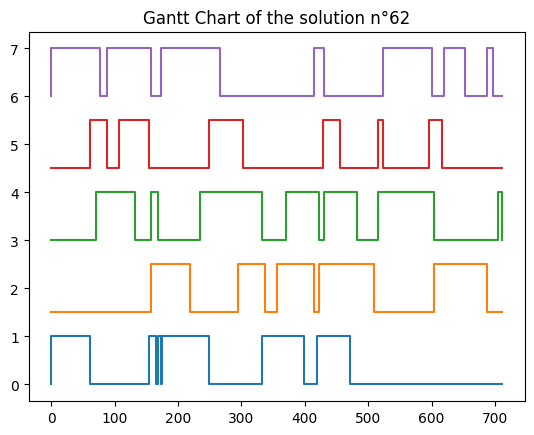

Makespan of the solution n°62 : 711
Regularity of the solution n°62 : 3232
Objective function of the solution n°62 : 2297952


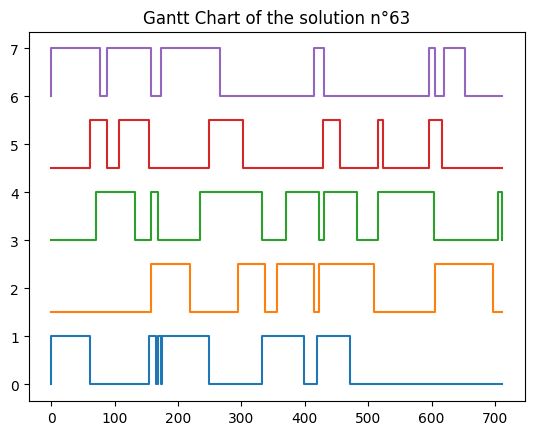

Makespan of the solution n°63 : 711
Regularity of the solution n°63 : 3232
Objective function of the solution n°63 : 2297952


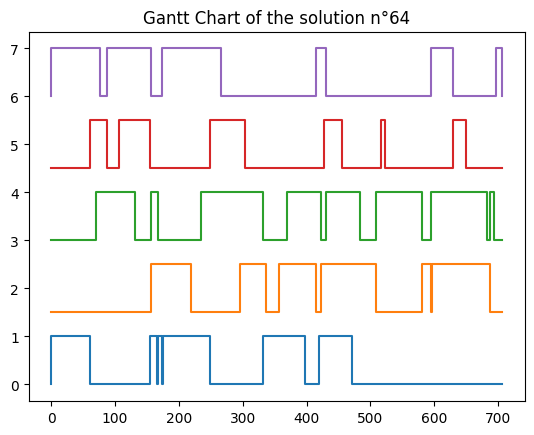

Makespan of the solution n°64 : 706
Regularity of the solution n°64 : 3258
Objective function of the solution n°64 : 2300148


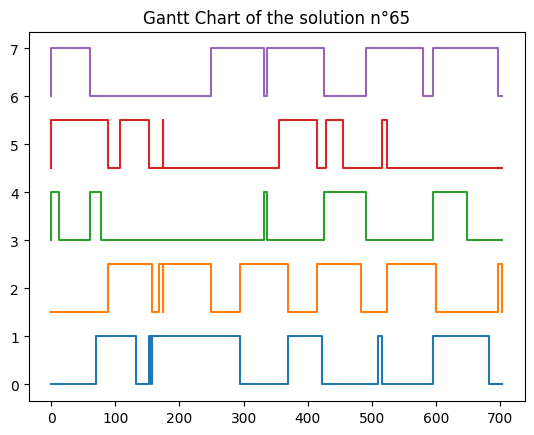

Makespan of the solution n°65 : 703
Regularity of the solution n°65 : 3274
Objective function of the solution n°65 : 2301622


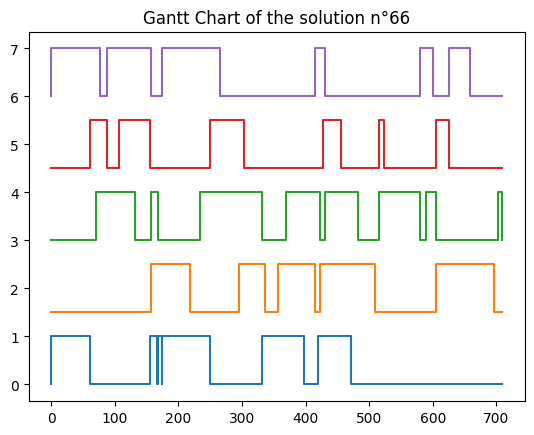

Makespan of the solution n°66 : 709
Regularity of the solution n°66 : 3248
Objective function of the solution n°66 : 2302832


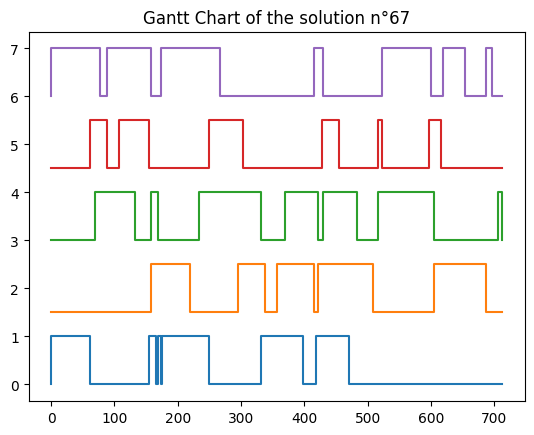

Makespan of the solution n°67 : 712
Regularity of the solution n°67 : 3236
Objective function of the solution n°67 : 2304032


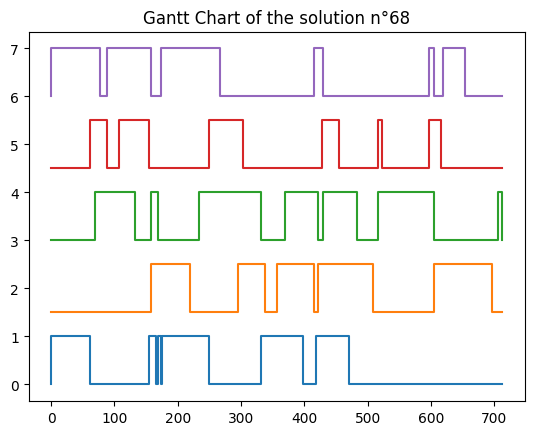

Makespan of the solution n°68 : 712
Regularity of the solution n°68 : 3236
Objective function of the solution n°68 : 2304032


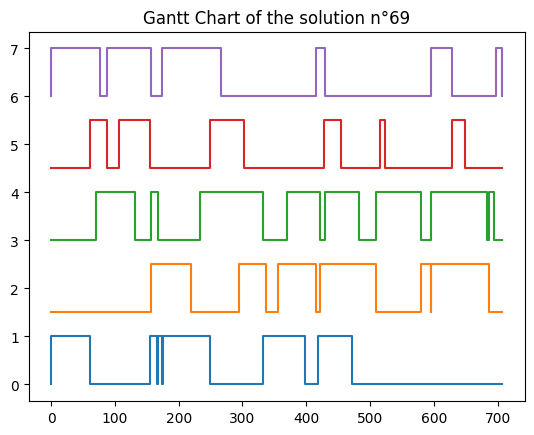

Makespan of the solution n°69 : 707
Regularity of the solution n°69 : 3260
Objective function of the solution n°69 : 2304820


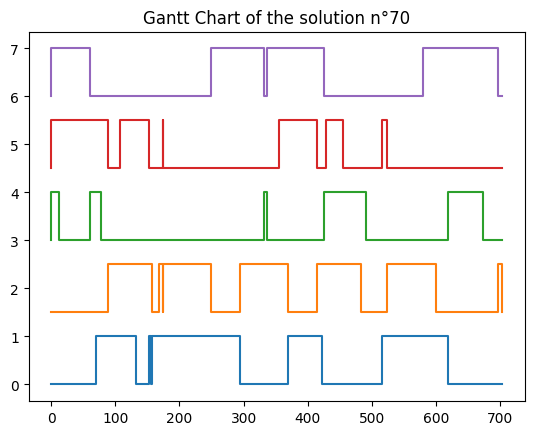

Makespan of the solution n°70 : 703
Regularity of the solution n°70 : 3280
Objective function of the solution n°70 : 2305840


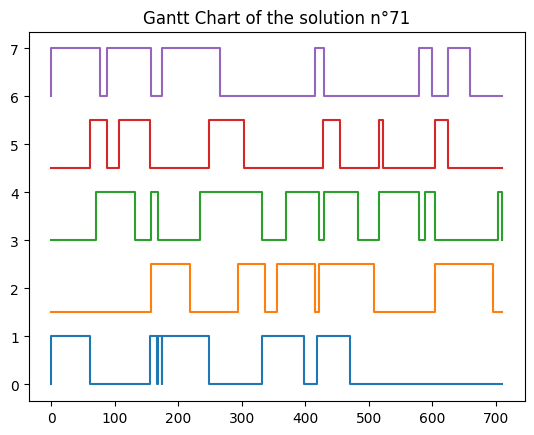

Makespan of the solution n°71 : 710
Regularity of the solution n°71 : 3252
Objective function of the solution n°71 : 2308920


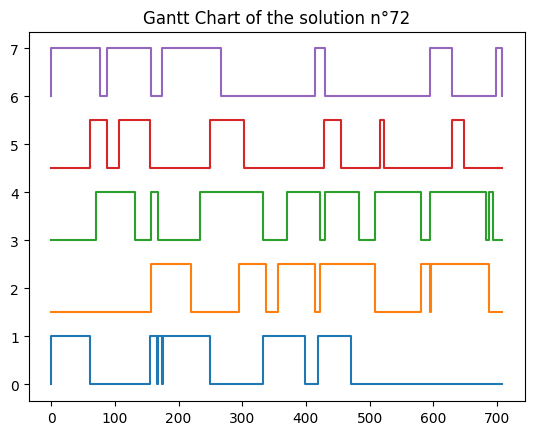

Makespan of the solution n°72 : 708
Regularity of the solution n°72 : 3262
Objective function of the solution n°72 : 2309496


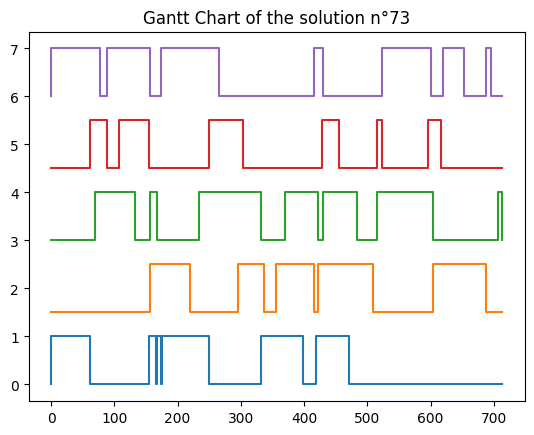

Makespan of the solution n°73 : 713
Regularity of the solution n°73 : 3240
Objective function of the solution n°73 : 2310120


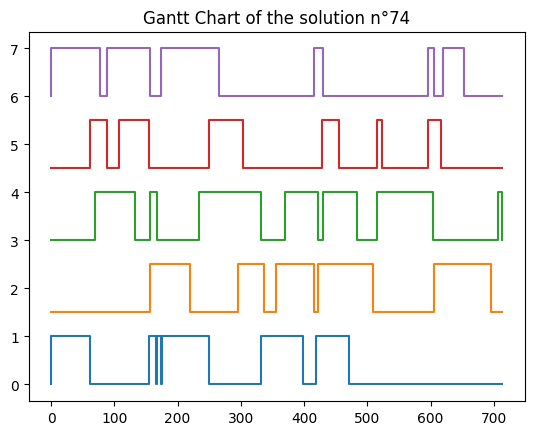

Makespan of the solution n°74 : 713
Regularity of the solution n°74 : 3240
Objective function of the solution n°74 : 2310120


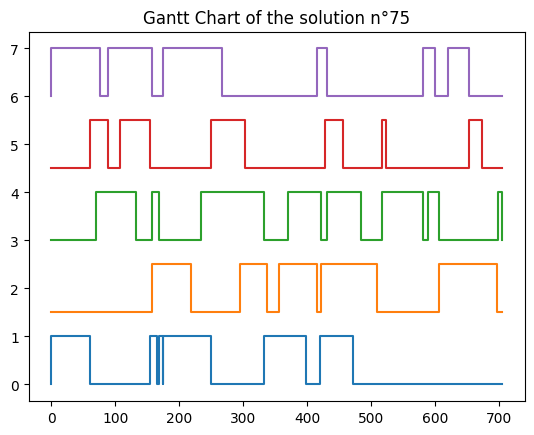

Makespan of the solution n°75 : 704
Regularity of the solution n°75 : 3284
Objective function of the solution n°75 : 2311936


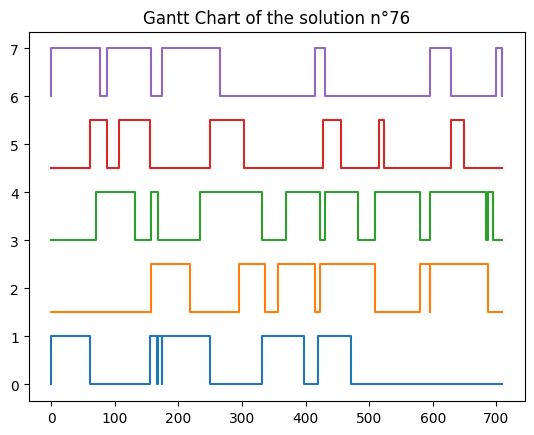

Makespan of the solution n°76 : 709
Regularity of the solution n°76 : 3264
Objective function of the solution n°76 : 2314176


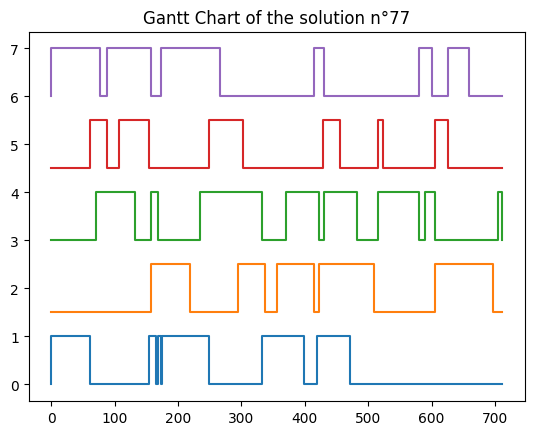

Makespan of the solution n°77 : 711
Regularity of the solution n°77 : 3256
Objective function of the solution n°77 : 2315016


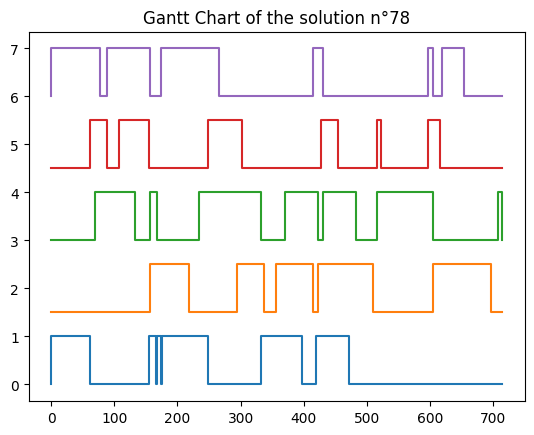

Makespan of the solution n°78 : 714
Regularity of the solution n°78 : 3244
Objective function of the solution n°78 : 2316216


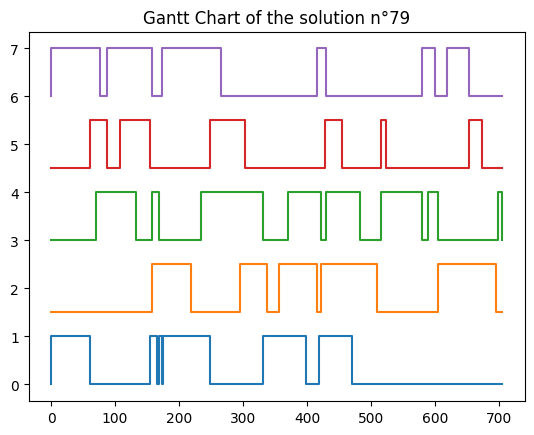

Makespan of the solution n°79 : 705
Regularity of the solution n°79 : 3288
Objective function of the solution n°79 : 2318040


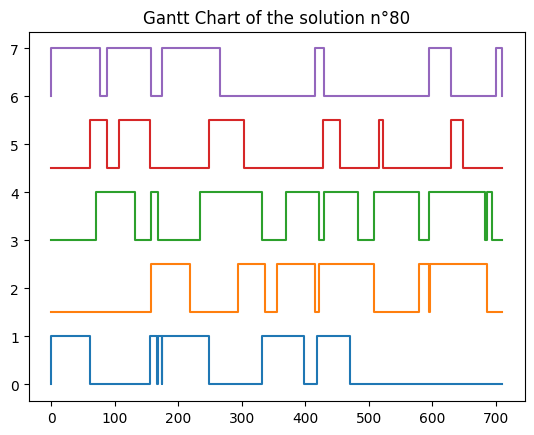

Makespan of the solution n°80 : 710
Regularity of the solution n°80 : 3266
Objective function of the solution n°80 : 2318860


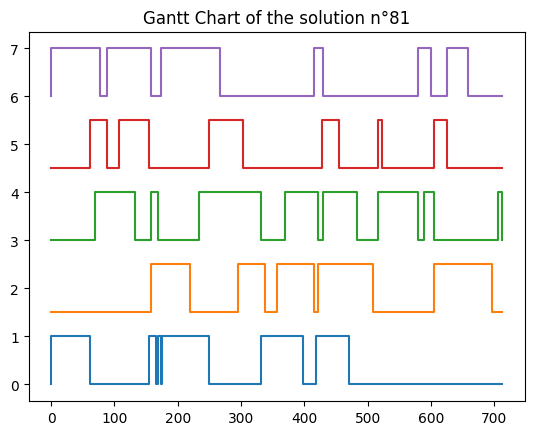

Makespan of the solution n°81 : 712
Regularity of the solution n°81 : 3260
Objective function of the solution n°81 : 2321120


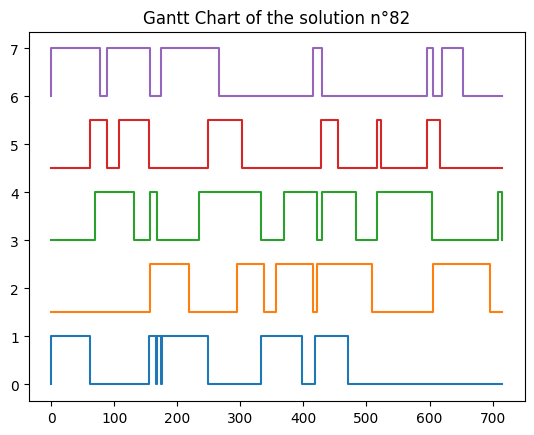

Makespan of the solution n°82 : 715
Regularity of the solution n°82 : 3248
Objective function of the solution n°82 : 2322320


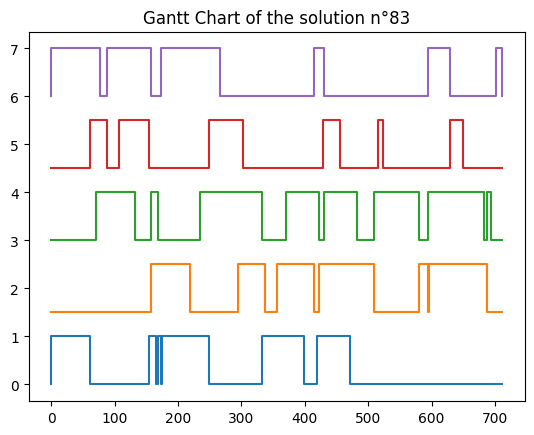

Makespan of the solution n°83 : 711
Regularity of the solution n°83 : 3268
Objective function of the solution n°83 : 2323548


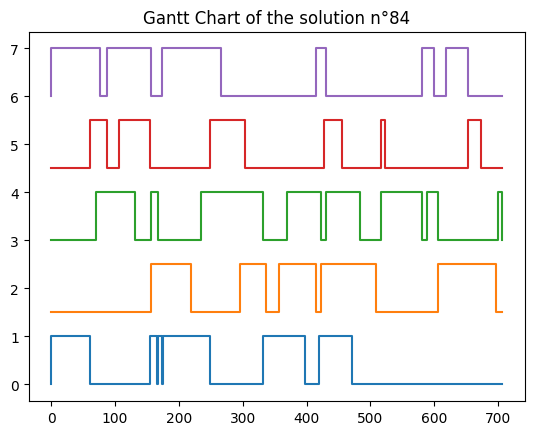

Makespan of the solution n°84 : 706
Regularity of the solution n°84 : 3292
Objective function of the solution n°84 : 2324152


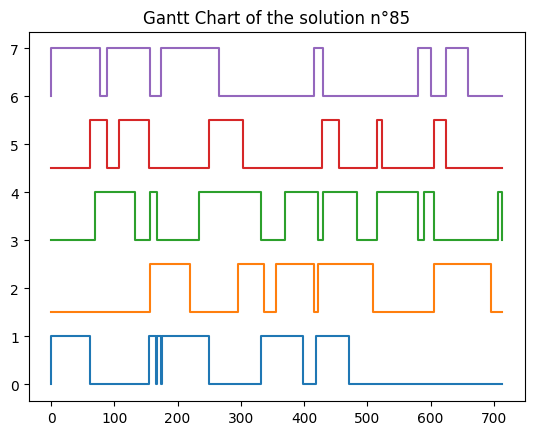

Makespan of the solution n°85 : 713
Regularity of the solution n°85 : 3264
Objective function of the solution n°85 : 2327232


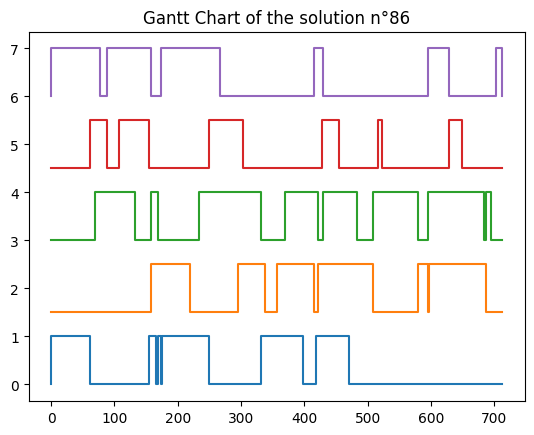

Makespan of the solution n°86 : 712
Regularity of the solution n°86 : 3270
Objective function of the solution n°86 : 2328240


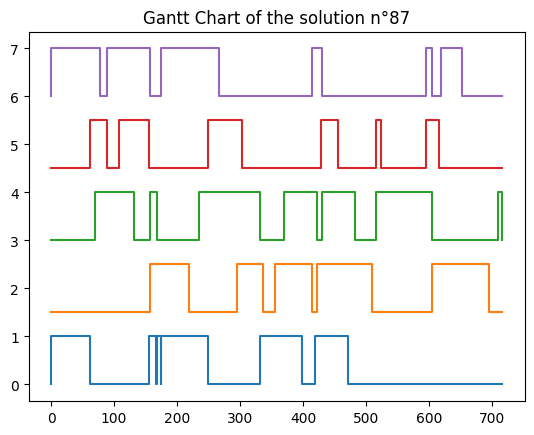

Makespan of the solution n°87 : 716
Regularity of the solution n°87 : 3252
Objective function of the solution n°87 : 2328432


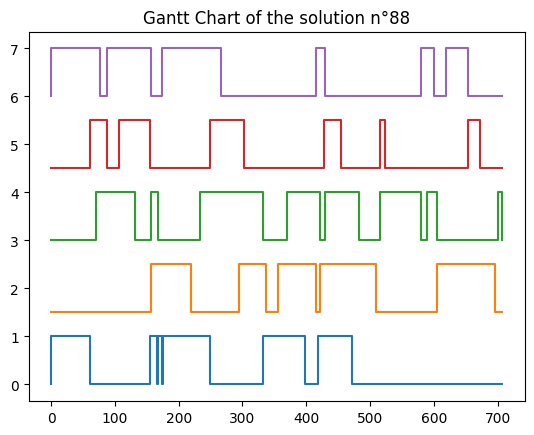

Makespan of the solution n°88 : 707
Regularity of the solution n°88 : 3296
Objective function of the solution n°88 : 2330272


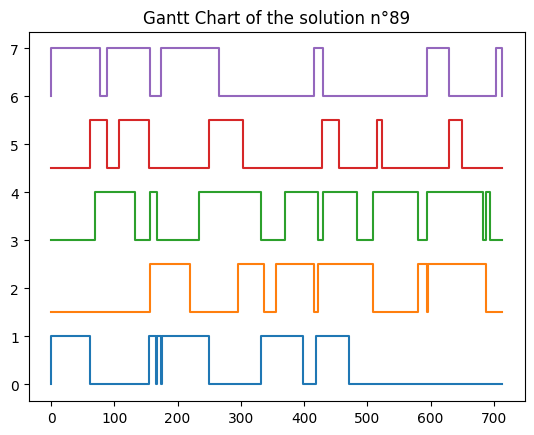

Makespan of the solution n°89 : 713
Regularity of the solution n°89 : 3272
Objective function of the solution n°89 : 2332936


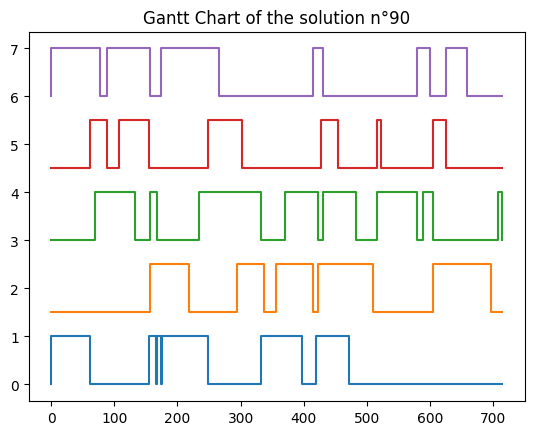

Makespan of the solution n°90 : 714
Regularity of the solution n°90 : 3268
Objective function of the solution n°90 : 2333352


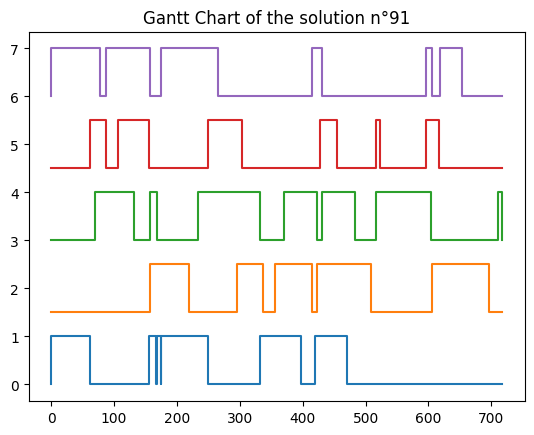

Makespan of the solution n°91 : 717
Regularity of the solution n°91 : 3256
Objective function of the solution n°91 : 2334552


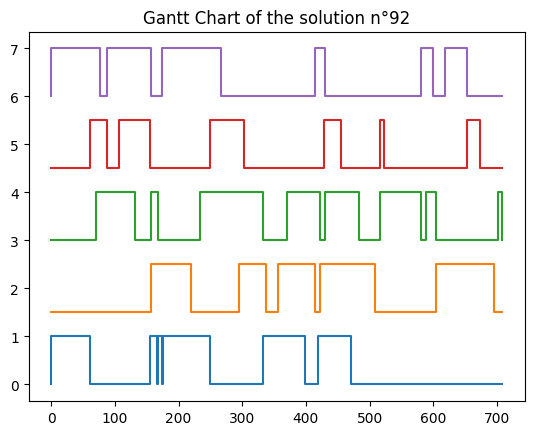

Makespan of the solution n°92 : 708
Regularity of the solution n°92 : 3300
Objective function of the solution n°92 : 2336400


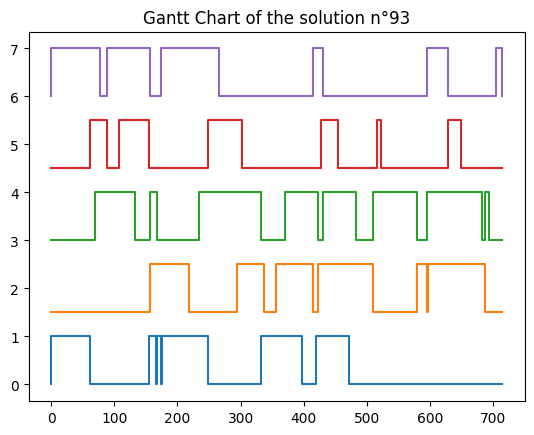

Makespan of the solution n°93 : 714
Regularity of the solution n°93 : 3274
Objective function of the solution n°93 : 2337636


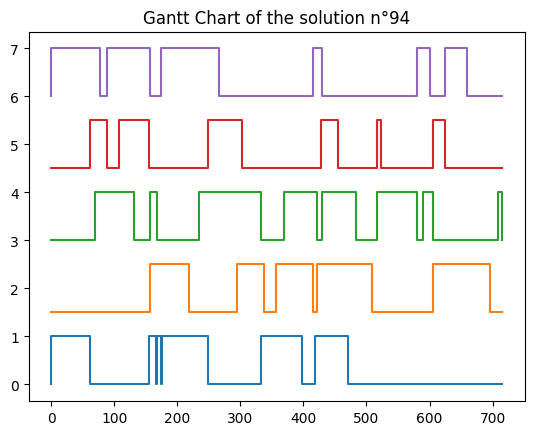

Makespan of the solution n°94 : 715
Regularity of the solution n°94 : 3272
Objective function of the solution n°94 : 2339480


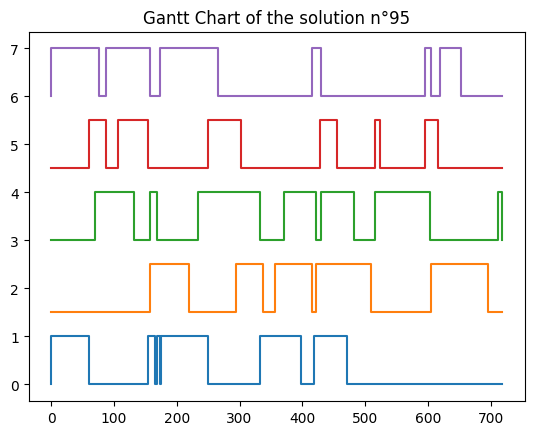

Makespan of the solution n°95 : 718
Regularity of the solution n°95 : 3260
Objective function of the solution n°95 : 2340680


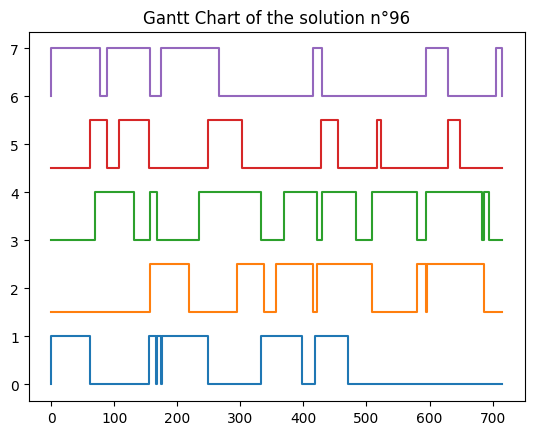

Makespan of the solution n°96 : 715
Regularity of the solution n°96 : 3276
Objective function of the solution n°96 : 2342340


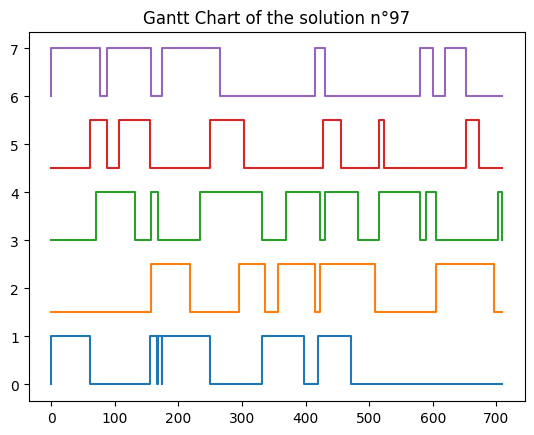

Makespan of the solution n°97 : 709
Regularity of the solution n°97 : 3304
Objective function of the solution n°97 : 2342536


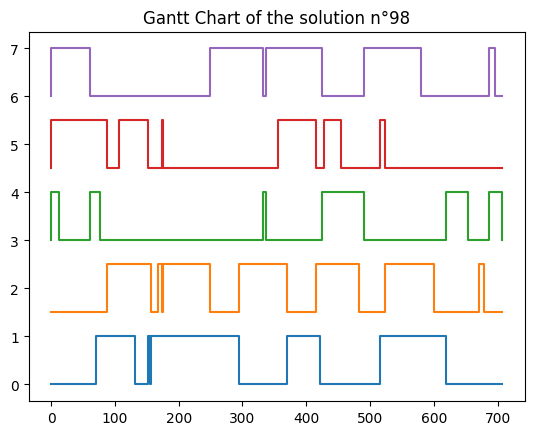

Makespan of the solution n°98 : 707
Regularity of the solution n°98 : 3316
Objective function of the solution n°98 : 2344412


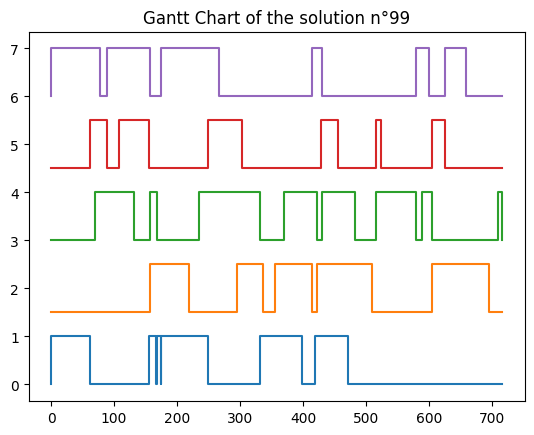

Makespan of the solution n°99 : 716
Regularity of the solution n°99 : 3276
Objective function of the solution n°99 : 2345616


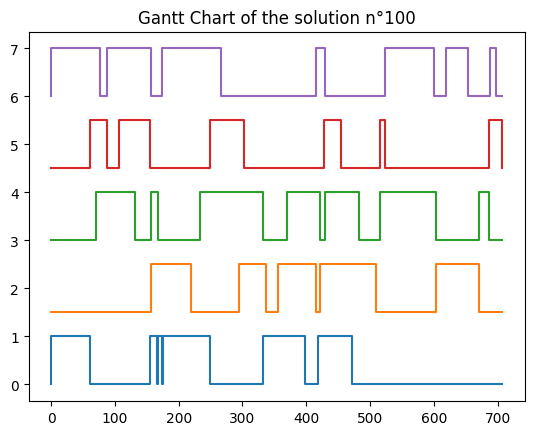

Makespan of the solution n°100 : 707
Regularity of the solution n°100 : 3318
Objective function of the solution n°100 : 2345826


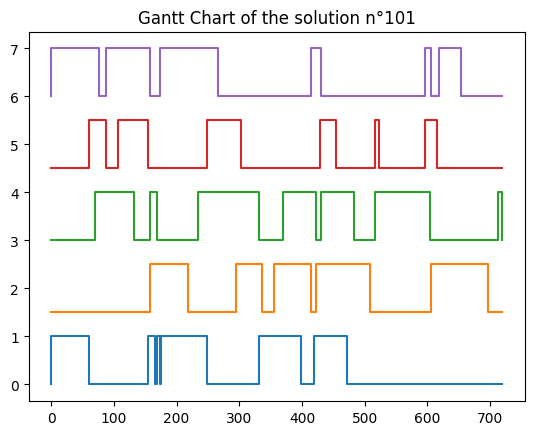

Makespan of the solution n°101 : 719
Regularity of the solution n°101 : 3264
Objective function of the solution n°101 : 2346816


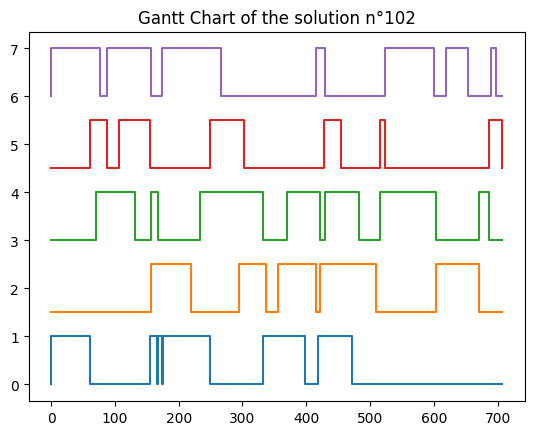

Makespan of the solution n°102 : 707
Regularity of the solution n°102 : 3320
Objective function of the solution n°102 : 2347240


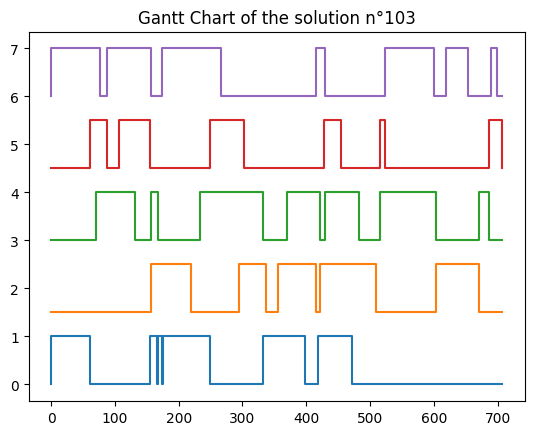

Makespan of the solution n°103 : 707
Regularity of the solution n°103 : 3322
Objective function of the solution n°103 : 2348654


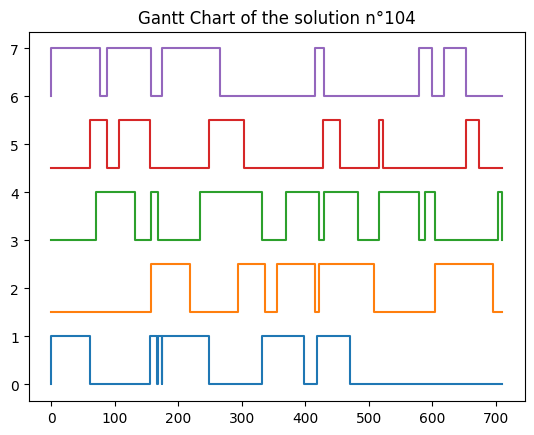

Makespan of the solution n°104 : 710
Regularity of the solution n°104 : 3308
Objective function of the solution n°104 : 2348680


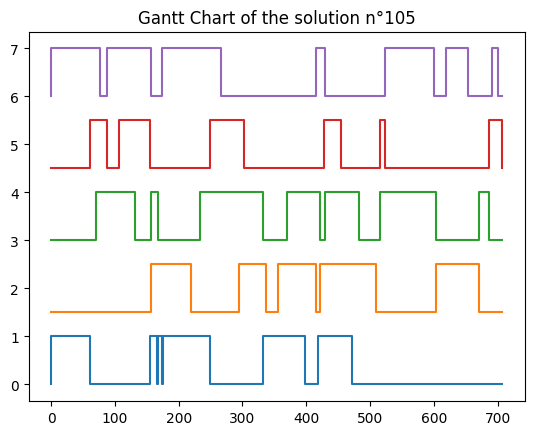

Makespan of the solution n°105 : 707
Regularity of the solution n°105 : 3324
Objective function of the solution n°105 : 2350068


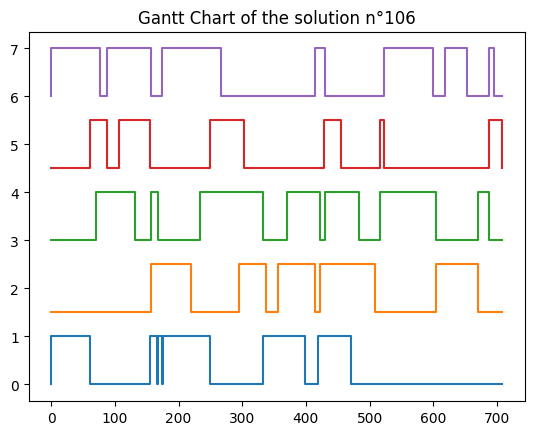

Makespan of the solution n°106 : 708
Regularity of the solution n°106 : 3320
Objective function of the solution n°106 : 2350560


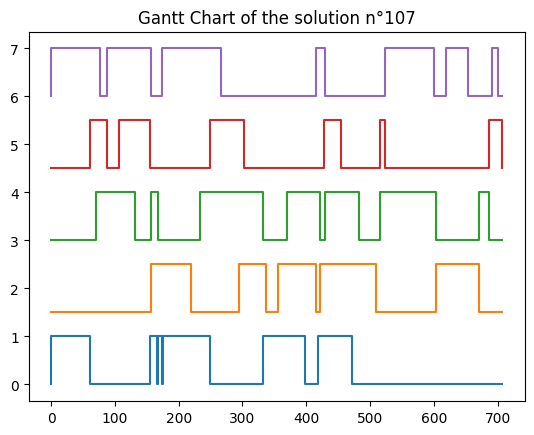

Makespan of the solution n°107 : 707
Regularity of the solution n°107 : 3326
Objective function of the solution n°107 : 2351482


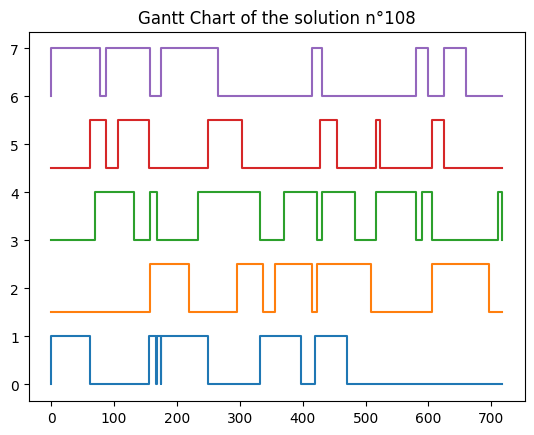

Makespan of the solution n°108 : 717
Regularity of the solution n°108 : 3280
Objective function of the solution n°108 : 2351760


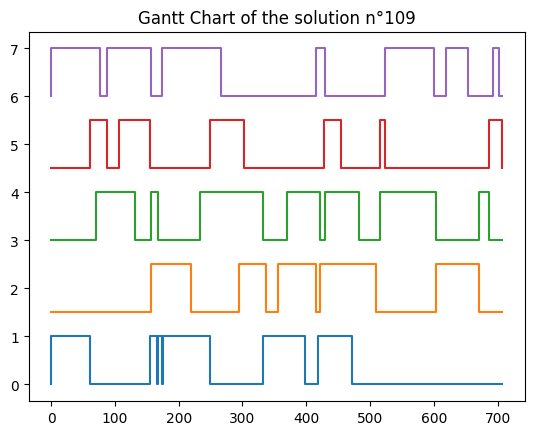

Makespan of the solution n°109 : 707
Regularity of the solution n°109 : 3328
Objective function of the solution n°109 : 2352896


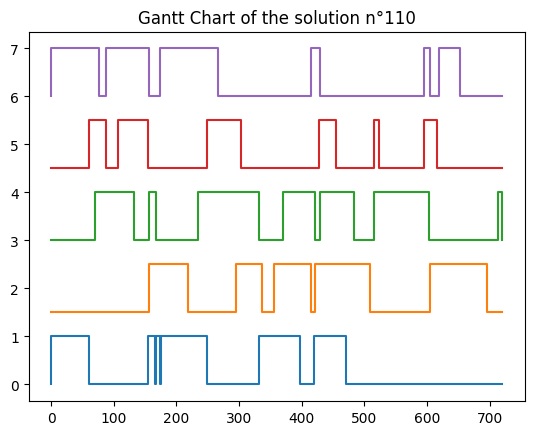

Makespan of the solution n°110 : 720
Regularity of the solution n°110 : 3268
Objective function of the solution n°110 : 2352960


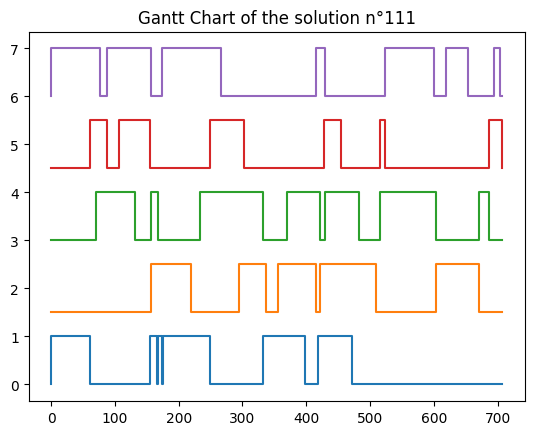

Makespan of the solution n°111 : 707
Regularity of the solution n°111 : 3330
Objective function of the solution n°111 : 2354310


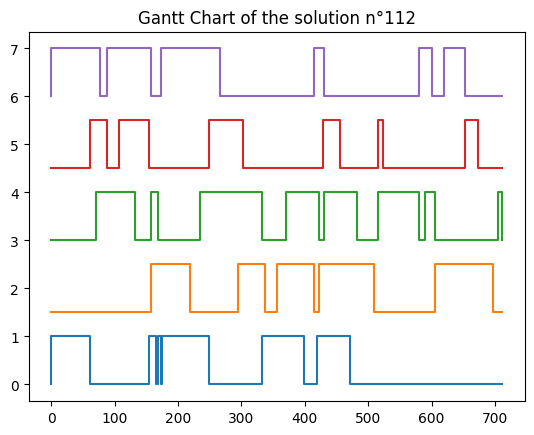

Makespan of the solution n°112 : 711
Regularity of the solution n°112 : 3312
Objective function of the solution n°112 : 2354832


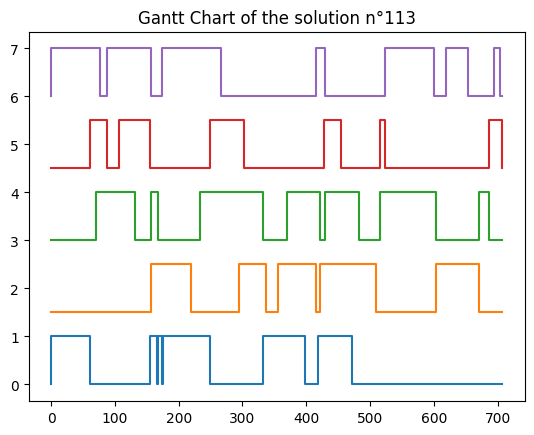

Makespan of the solution n°113 : 707
Regularity of the solution n°113 : 3332
Objective function of the solution n°113 : 2355724


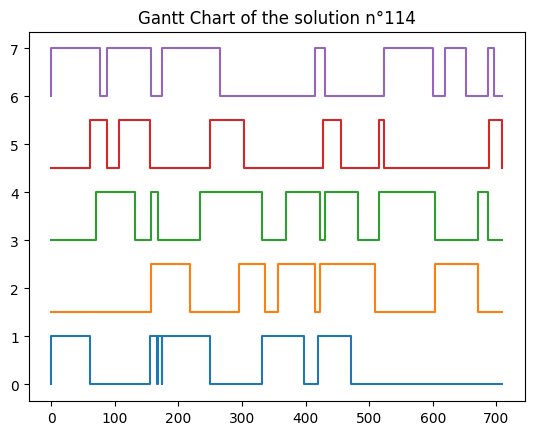

Makespan of the solution n°114 : 709
Regularity of the solution n°114 : 3324
Objective function of the solution n°114 : 2356716


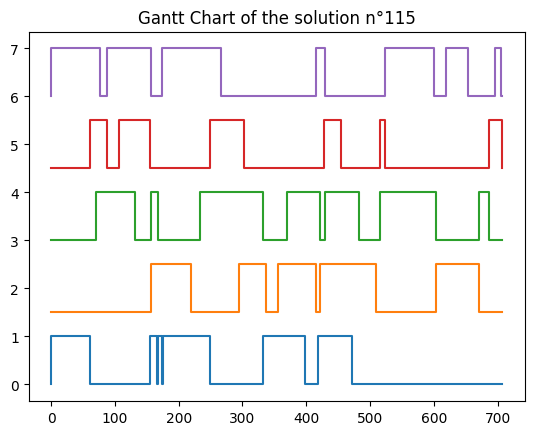

Makespan of the solution n°115 : 707
Regularity of the solution n°115 : 3334
Objective function of the solution n°115 : 2357138


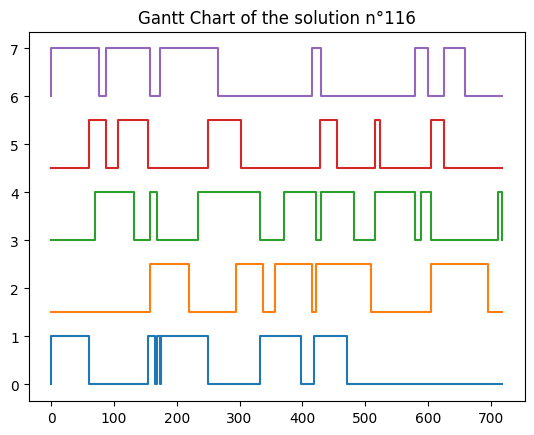

Makespan of the solution n°116 : 718
Regularity of the solution n°116 : 3284
Objective function of the solution n°116 : 2357912


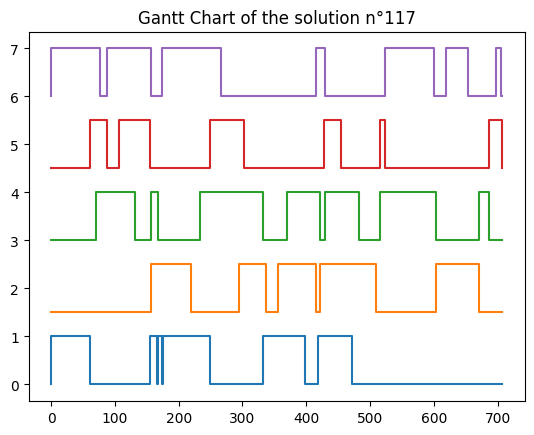

Makespan of the solution n°117 : 707
Regularity of the solution n°117 : 3336
Objective function of the solution n°117 : 2358552


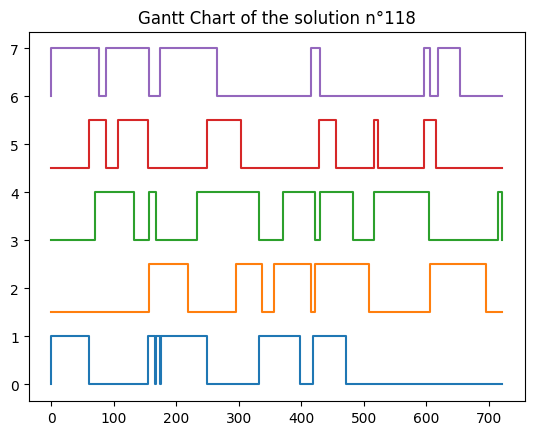

Makespan of the solution n°118 : 721
Regularity of the solution n°118 : 3272
Objective function of the solution n°118 : 2359112


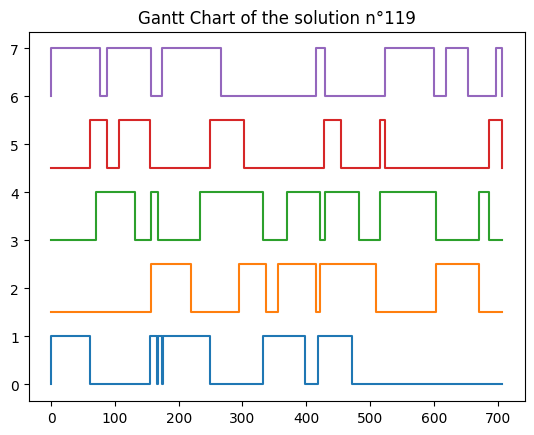

Makespan of the solution n°119 : 707
Regularity of the solution n°119 : 3338
Objective function of the solution n°119 : 2359966


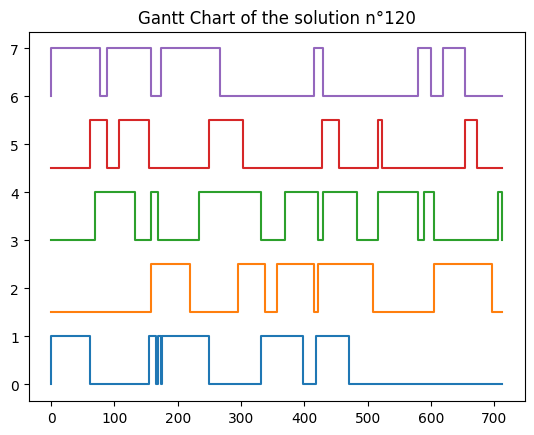

Makespan of the solution n°120 : 712
Regularity of the solution n°120 : 3316
Objective function of the solution n°120 : 2360992


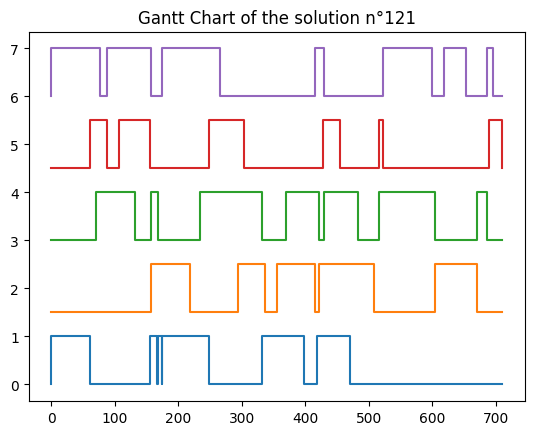

Makespan of the solution n°121 : 710
Regularity of the solution n°121 : 3328
Objective function of the solution n°121 : 2362880


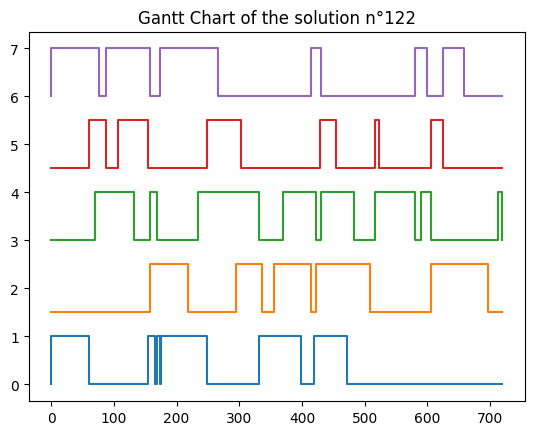

Makespan of the solution n°122 : 719
Regularity of the solution n°122 : 3288
Objective function of the solution n°122 : 2364072


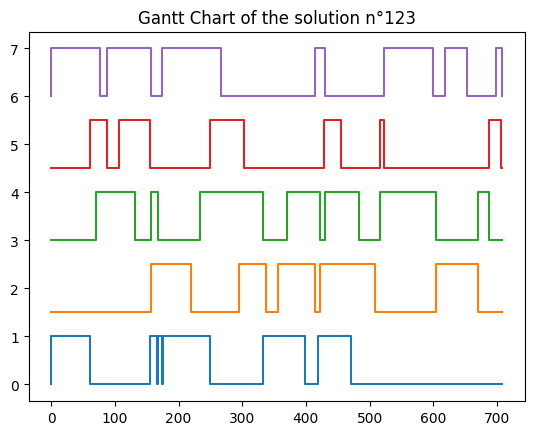

Makespan of the solution n°123 : 708
Regularity of the solution n°123 : 3340
Objective function of the solution n°123 : 2364720


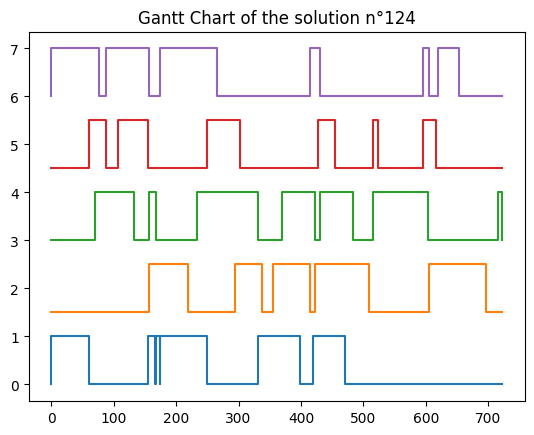

Makespan of the solution n°124 : 722
Regularity of the solution n°124 : 3276
Objective function of the solution n°124 : 2365272


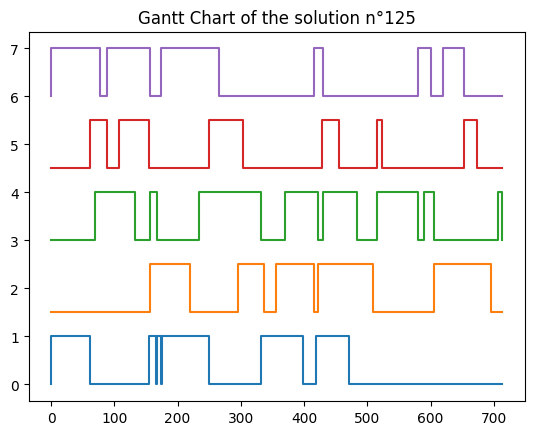

Makespan of the solution n°125 : 713
Regularity of the solution n°125 : 3320
Objective function of the solution n°125 : 2367160


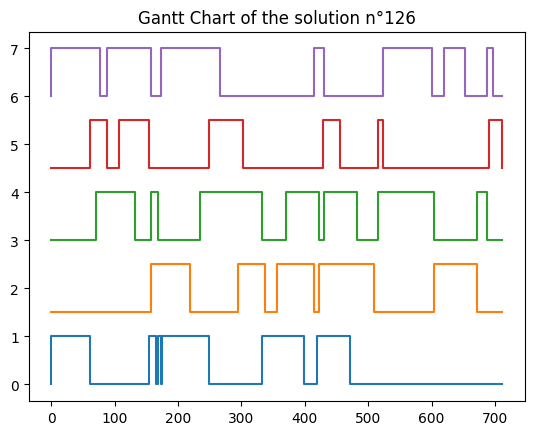

Makespan of the solution n°126 : 711
Regularity of the solution n°126 : 3332
Objective function of the solution n°126 : 2369052


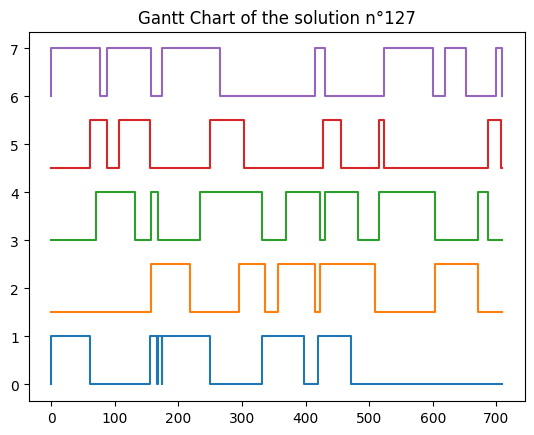

Makespan of the solution n°127 : 709
Regularity of the solution n°127 : 3342
Objective function of the solution n°127 : 2369478


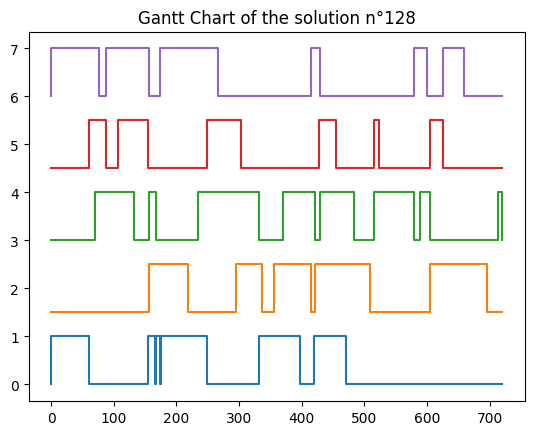

Makespan of the solution n°128 : 720
Regularity of the solution n°128 : 3292
Objective function of the solution n°128 : 2370240


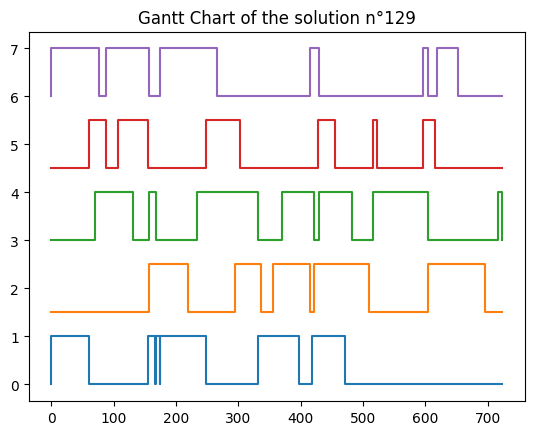

Makespan of the solution n°129 : 723
Regularity of the solution n°129 : 3280
Objective function of the solution n°129 : 2371440


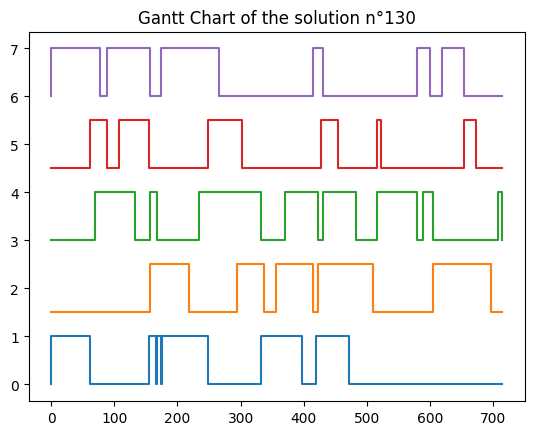

Makespan of the solution n°130 : 714
Regularity of the solution n°130 : 3324
Objective function of the solution n°130 : 2373336


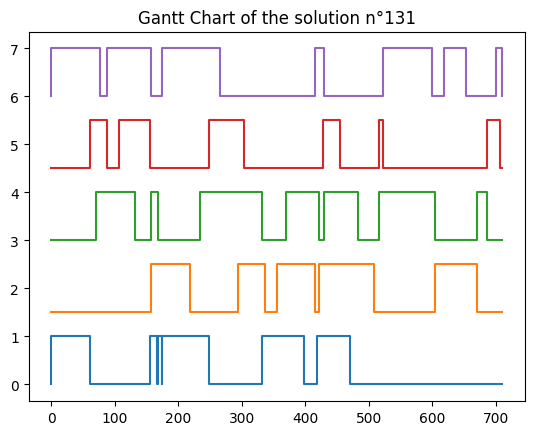

Makespan of the solution n°131 : 710
Regularity of the solution n°131 : 3344
Objective function of the solution n°131 : 2374240


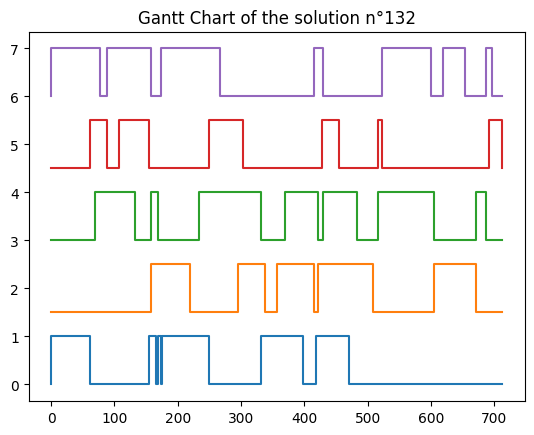

Makespan of the solution n°132 : 712
Regularity of the solution n°132 : 3336
Objective function of the solution n°132 : 2375232


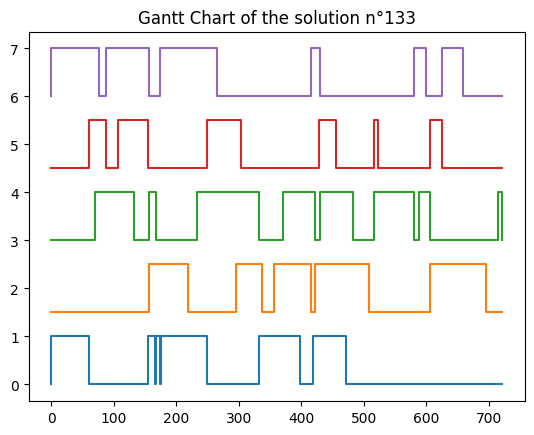

Makespan of the solution n°133 : 721
Regularity of the solution n°133 : 3296
Objective function of the solution n°133 : 2376416


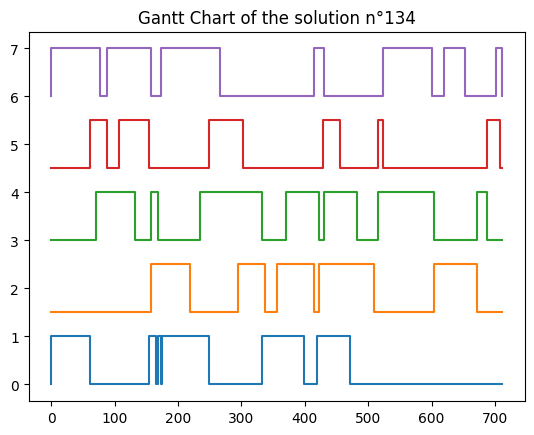

Makespan of the solution n°134 : 711
Regularity of the solution n°134 : 3346
Objective function of the solution n°134 : 2379006


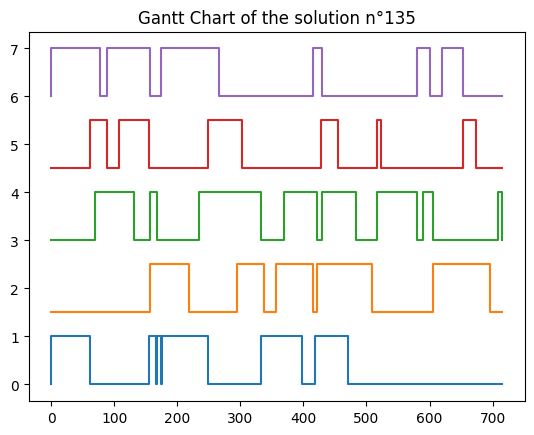

Makespan of the solution n°135 : 715
Regularity of the solution n°135 : 3328
Objective function of the solution n°135 : 2379520


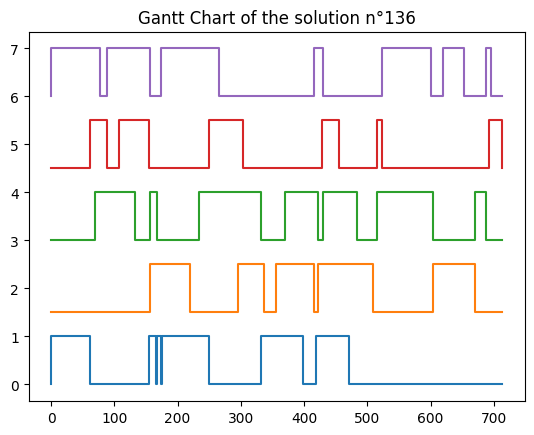

Makespan of the solution n°136 : 713
Regularity of the solution n°136 : 3340
Objective function of the solution n°136 : 2381420


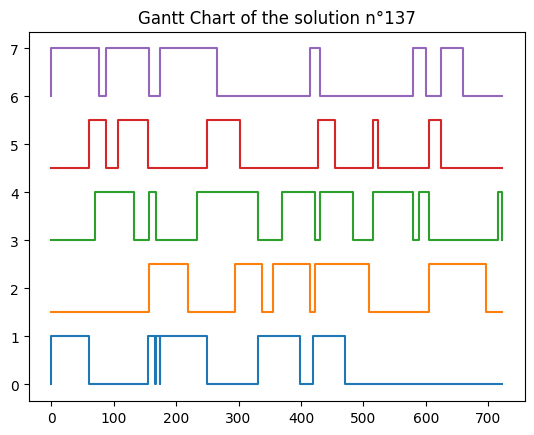

Makespan of the solution n°137 : 722
Regularity of the solution n°137 : 3300
Objective function of the solution n°137 : 2382600


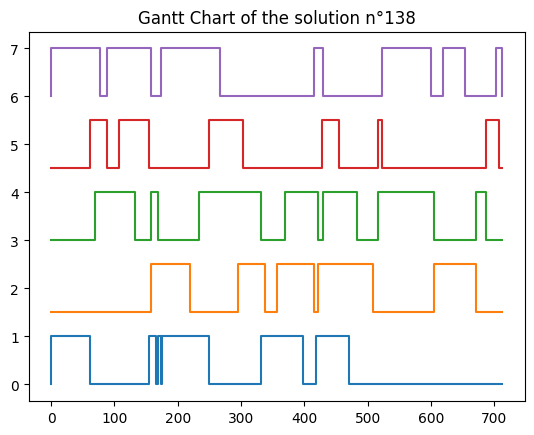

Makespan of the solution n°138 : 712
Regularity of the solution n°138 : 3348
Objective function of the solution n°138 : 2383776


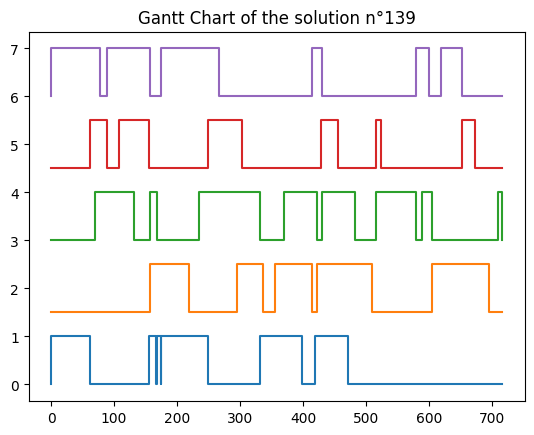

Makespan of the solution n°139 : 716
Regularity of the solution n°139 : 3332
Objective function of the solution n°139 : 2385712


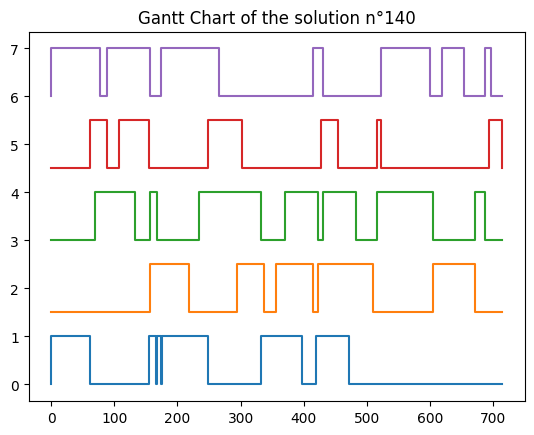

Makespan of the solution n°140 : 714
Regularity of the solution n°140 : 3344
Objective function of the solution n°140 : 2387616


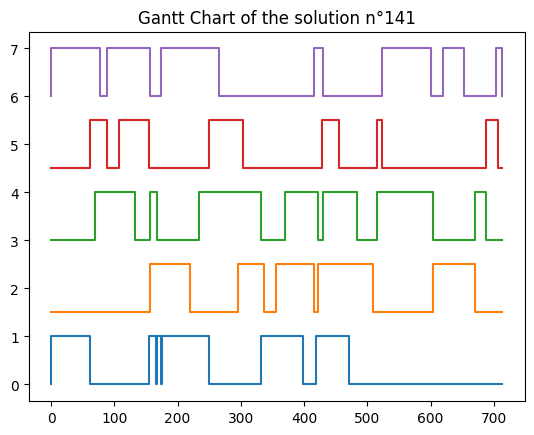

Makespan of the solution n°141 : 713
Regularity of the solution n°141 : 3350
Objective function of the solution n°141 : 2388550


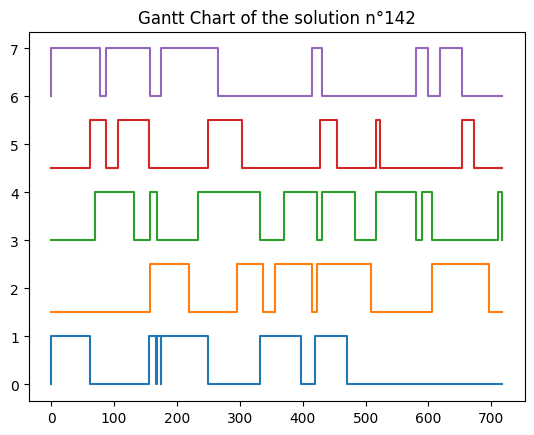

Makespan of the solution n°142 : 717
Regularity of the solution n°142 : 3336
Objective function of the solution n°142 : 2391912


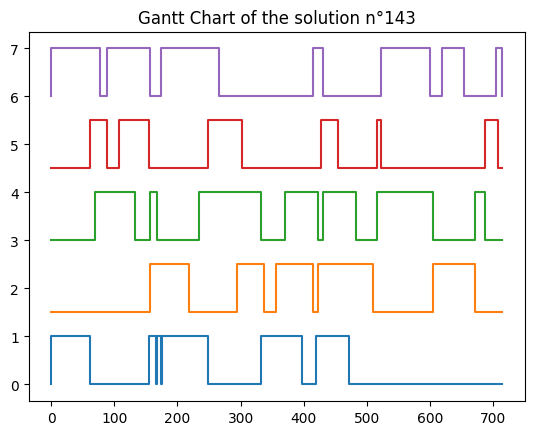

Makespan of the solution n°143 : 714
Regularity of the solution n°143 : 3352
Objective function of the solution n°143 : 2393328


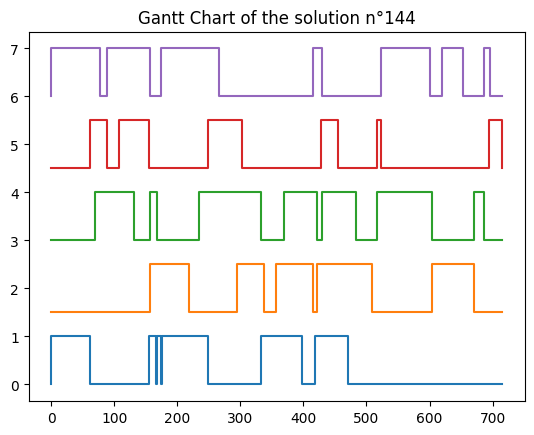

Makespan of the solution n°144 : 715
Regularity of the solution n°144 : 3348
Objective function of the solution n°144 : 2393820


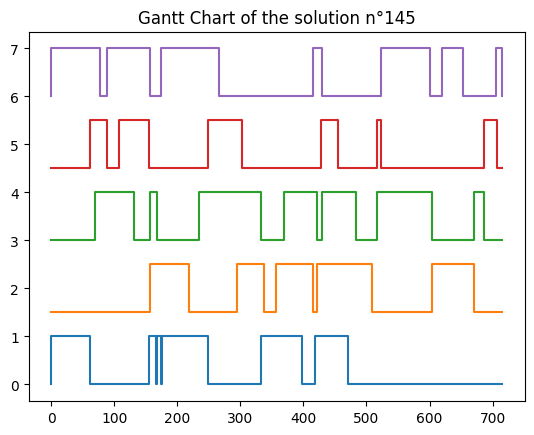

Makespan of the solution n°145 : 715
Regularity of the solution n°145 : 3354
Objective function of the solution n°145 : 2398110


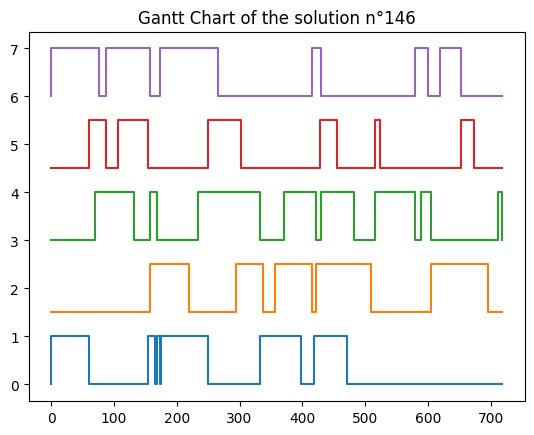

Makespan of the solution n°146 : 718
Regularity of the solution n°146 : 3340
Objective function of the solution n°146 : 2398120


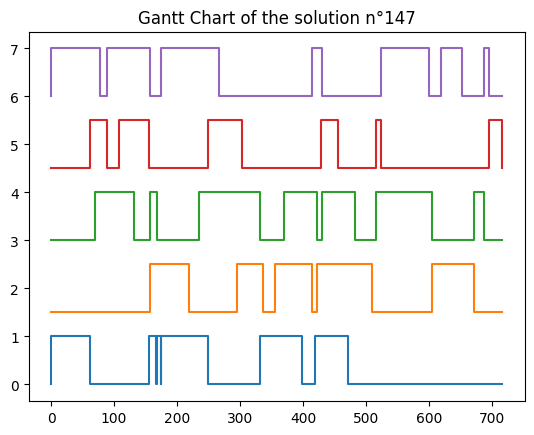

Makespan of the solution n°147 : 716
Regularity of the solution n°147 : 3352
Objective function of the solution n°147 : 2400032


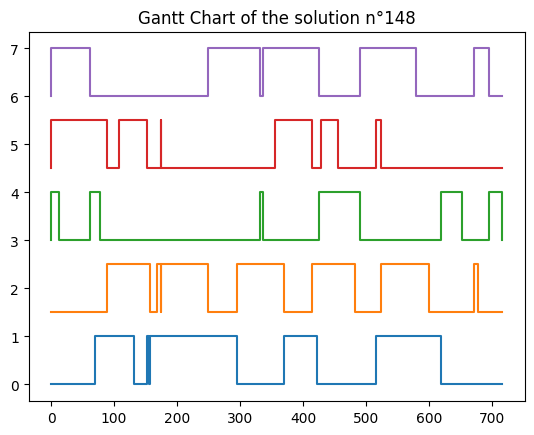

Makespan of the solution n°148 : 716
Regularity of the solution n°148 : 3352
Objective function of the solution n°148 : 2400032


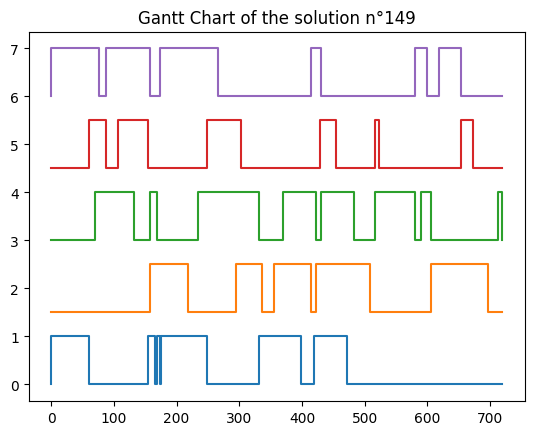

Makespan of the solution n°149 : 719
Regularity of the solution n°149 : 3344
Objective function of the solution n°149 : 2404336


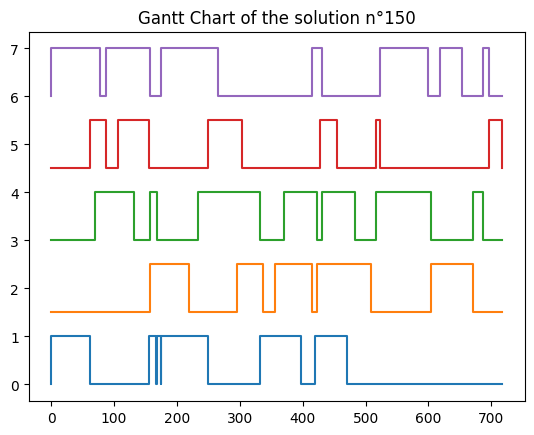

Makespan of the solution n°150 : 717
Regularity of the solution n°150 : 3356
Objective function of the solution n°150 : 2406252


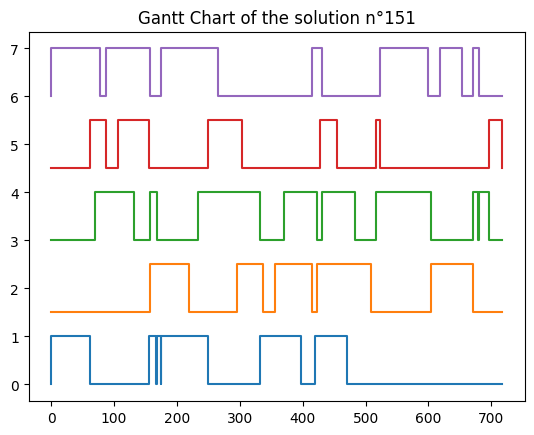

Makespan of the solution n°151 : 717
Regularity of the solution n°151 : 3356
Objective function of the solution n°151 : 2406252


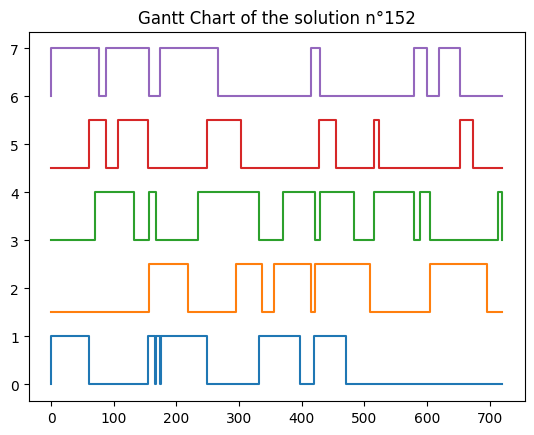

Makespan of the solution n°152 : 720
Regularity of the solution n°152 : 3348
Objective function of the solution n°152 : 2410560


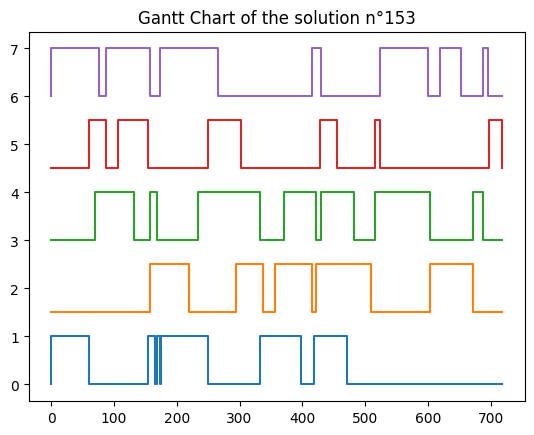

Makespan of the solution n°153 : 718
Regularity of the solution n°153 : 3360
Objective function of the solution n°153 : 2412480


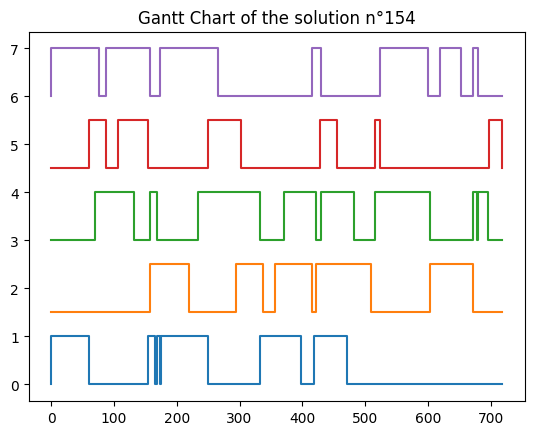

Makespan of the solution n°154 : 718
Regularity of the solution n°154 : 3360
Objective function of the solution n°154 : 2412480


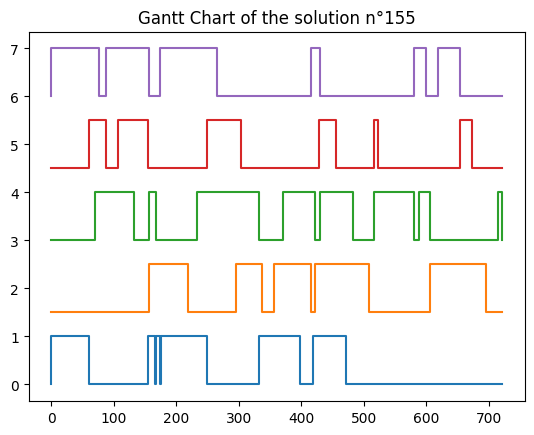

Makespan of the solution n°155 : 721
Regularity of the solution n°155 : 3352
Objective function of the solution n°155 : 2416792


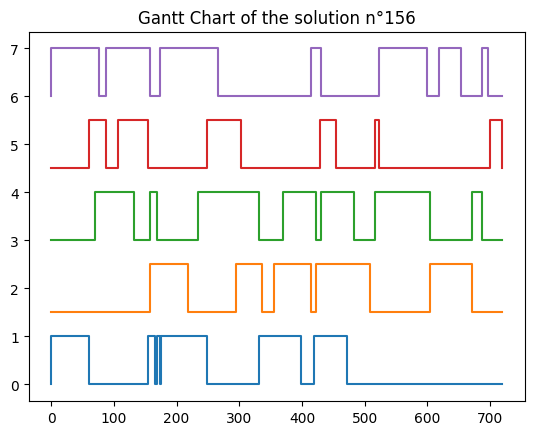

Makespan of the solution n°156 : 719
Regularity of the solution n°156 : 3364
Objective function of the solution n°156 : 2418716


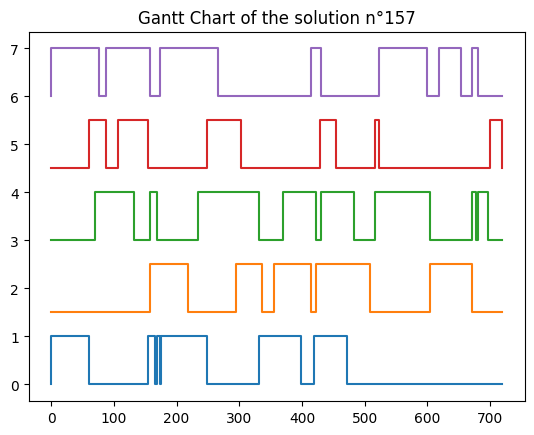

Makespan of the solution n°157 : 719
Regularity of the solution n°157 : 3364
Objective function of the solution n°157 : 2418716


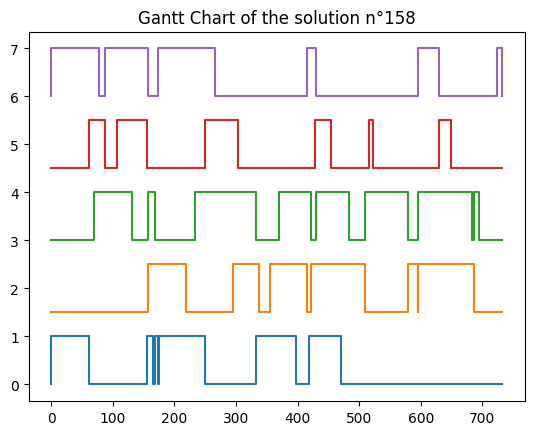

Makespan of the solution n°158 : 732
Regularity of the solution n°158 : 3310
Objective function of the solution n°158 : 2422920


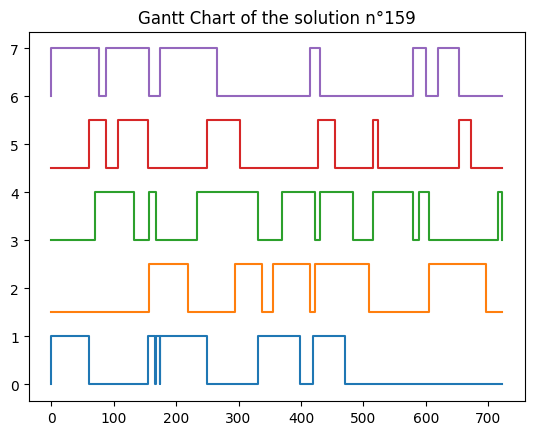

Makespan of the solution n°159 : 722
Regularity of the solution n°159 : 3356
Objective function of the solution n°159 : 2423032


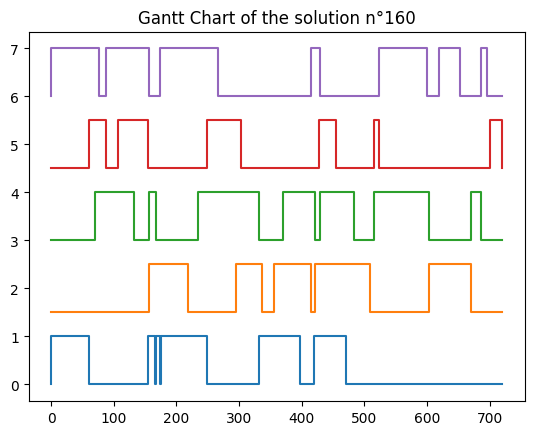

Makespan of the solution n°160 : 720
Regularity of the solution n°160 : 3368
Objective function of the solution n°160 : 2424960


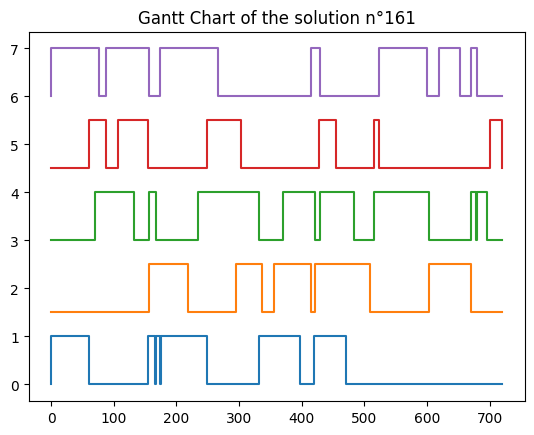

Makespan of the solution n°161 : 720
Regularity of the solution n°161 : 3368
Objective function of the solution n°161 : 2424960


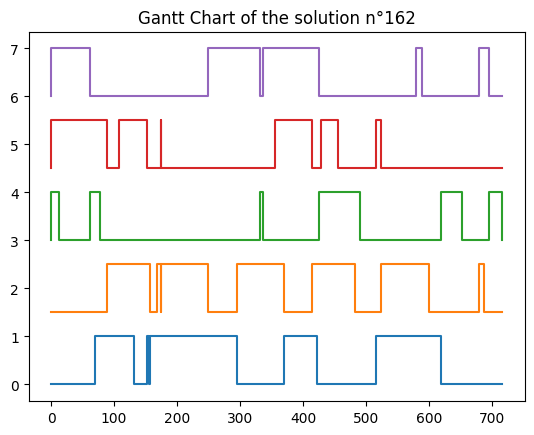

Makespan of the solution n°162 : 716
Regularity of the solution n°162 : 3388
Objective function of the solution n°162 : 2425808


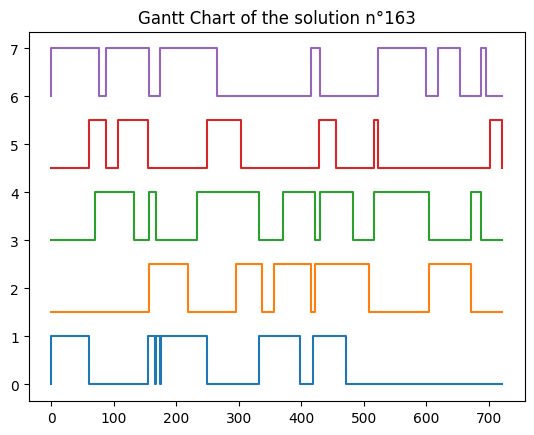

Makespan of the solution n°163 : 721
Regularity of the solution n°163 : 3372
Objective function of the solution n°163 : 2431212


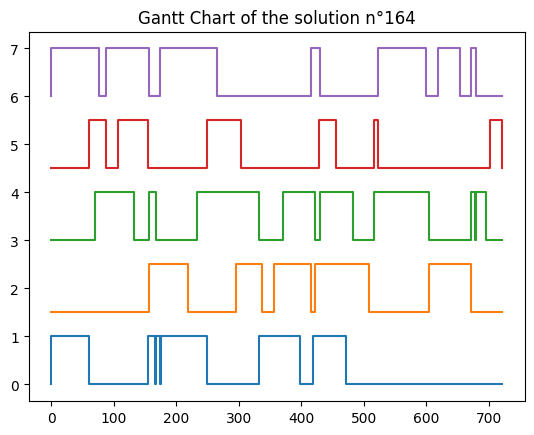

Makespan of the solution n°164 : 721
Regularity of the solution n°164 : 3372
Objective function of the solution n°164 : 2431212


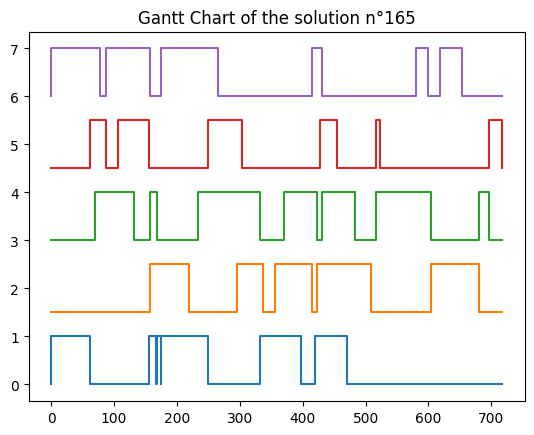

Makespan of the solution n°165 : 717
Regularity of the solution n°165 : 3392
Objective function of the solution n°165 : 2432064


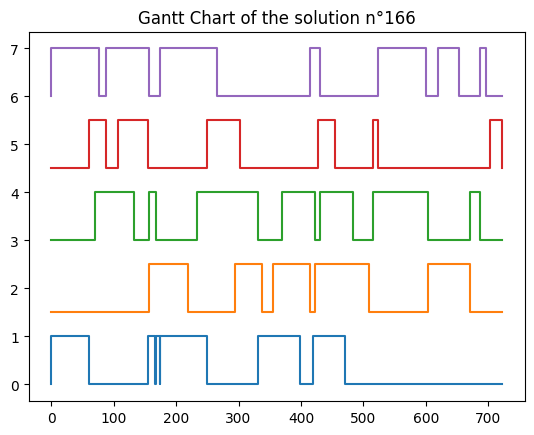

Makespan of the solution n°166 : 722
Regularity of the solution n°166 : 3376
Objective function of the solution n°166 : 2437472


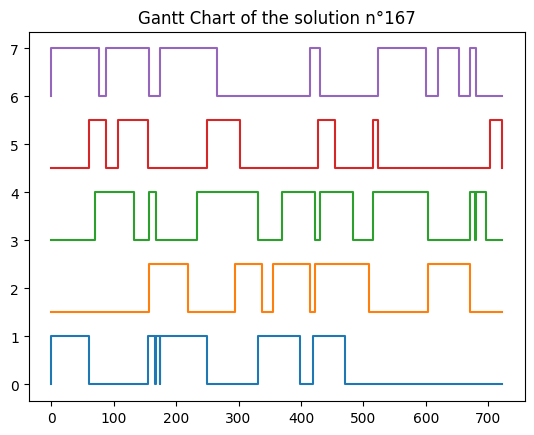

Makespan of the solution n°167 : 722
Regularity of the solution n°167 : 3376
Objective function of the solution n°167 : 2437472


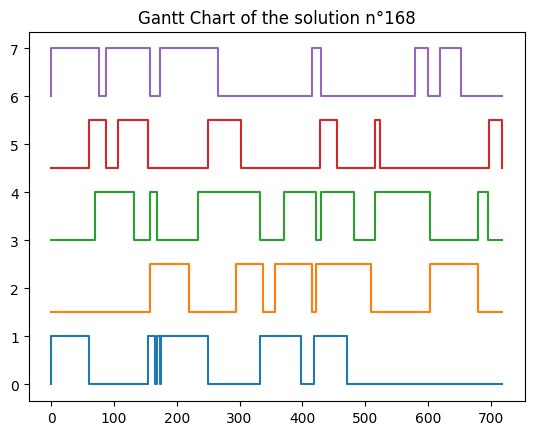

Makespan of the solution n°168 : 718
Regularity of the solution n°168 : 3396
Objective function of the solution n°168 : 2438328


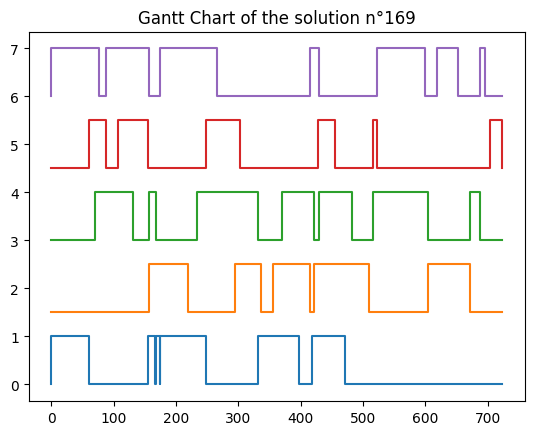

Makespan of the solution n°169 : 723
Regularity of the solution n°169 : 3380
Objective function of the solution n°169 : 2443740


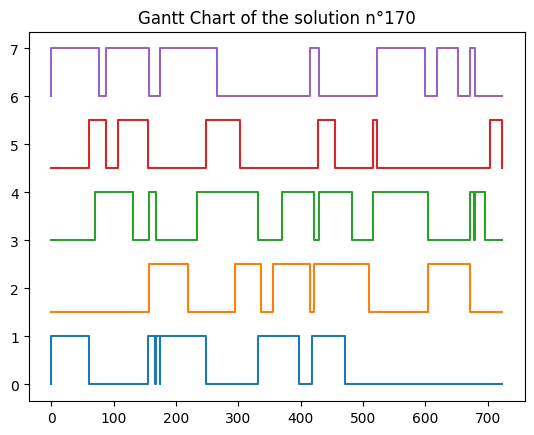

Makespan of the solution n°170 : 723
Regularity of the solution n°170 : 3380
Objective function of the solution n°170 : 2443740


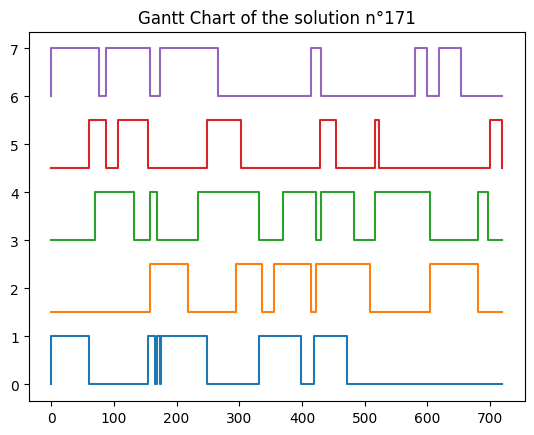

Makespan of the solution n°171 : 719
Regularity of the solution n°171 : 3400
Objective function of the solution n°171 : 2444600


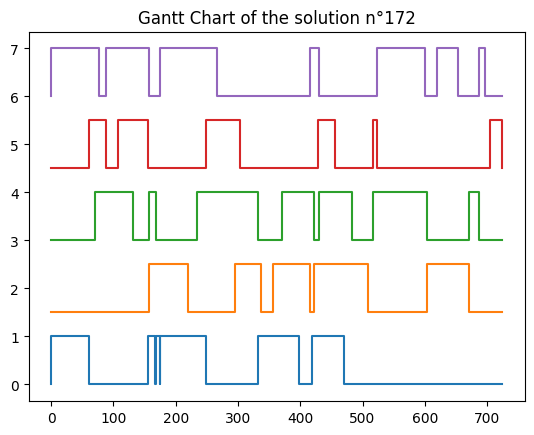

Makespan of the solution n°172 : 724
Regularity of the solution n°172 : 3384
Objective function of the solution n°172 : 2450016


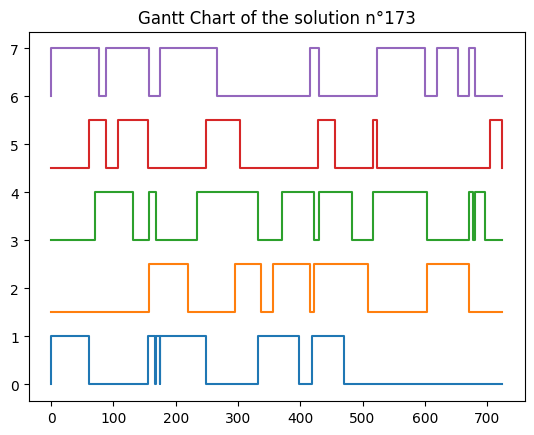

Makespan of the solution n°173 : 724
Regularity of the solution n°173 : 3384
Objective function of the solution n°173 : 2450016


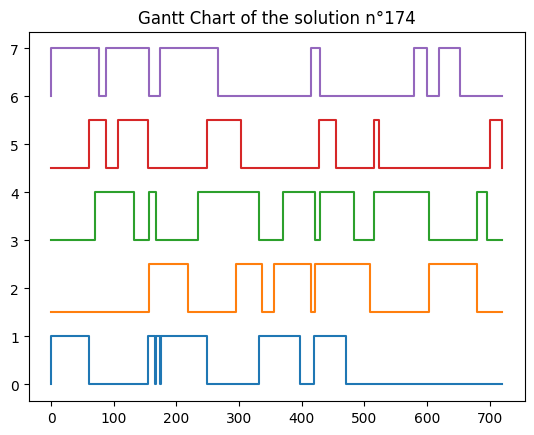

Makespan of the solution n°174 : 720
Regularity of the solution n°174 : 3404
Objective function of the solution n°174 : 2450880


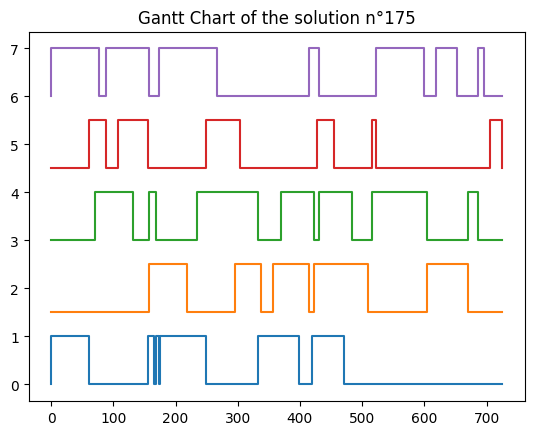

Makespan of the solution n°175 : 725
Regularity of the solution n°175 : 3388
Objective function of the solution n°175 : 2456300


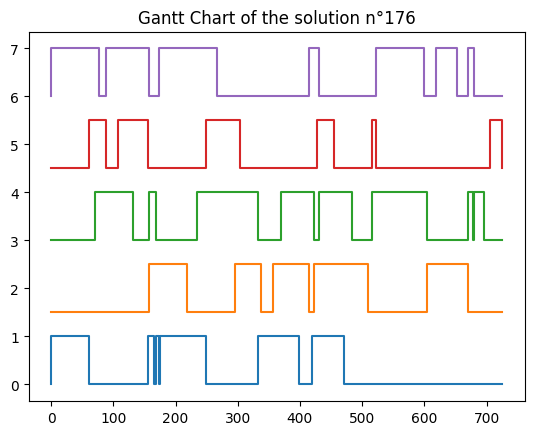

Makespan of the solution n°176 : 725
Regularity of the solution n°176 : 3388
Objective function of the solution n°176 : 2456300


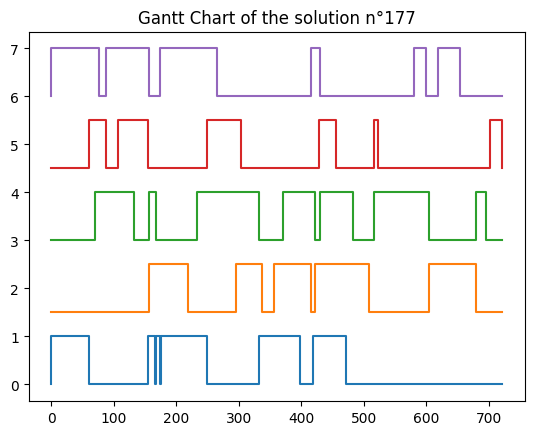

Makespan of the solution n°177 : 721
Regularity of the solution n°177 : 3408
Objective function of the solution n°177 : 2457168


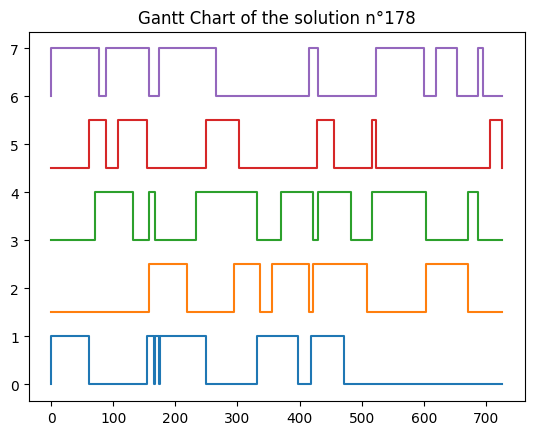

Makespan of the solution n°178 : 726
Regularity of the solution n°178 : 3392
Objective function of the solution n°178 : 2462592


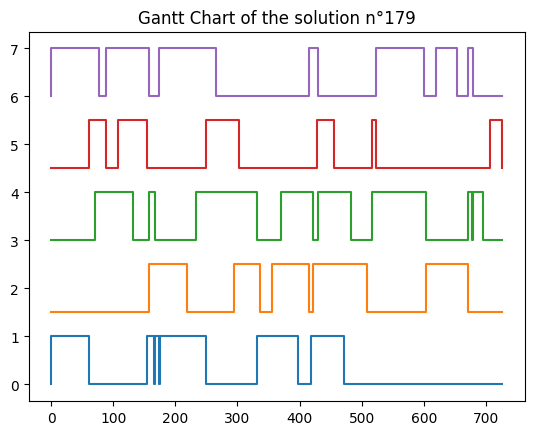

Makespan of the solution n°179 : 726
Regularity of the solution n°179 : 3392
Objective function of the solution n°179 : 2462592


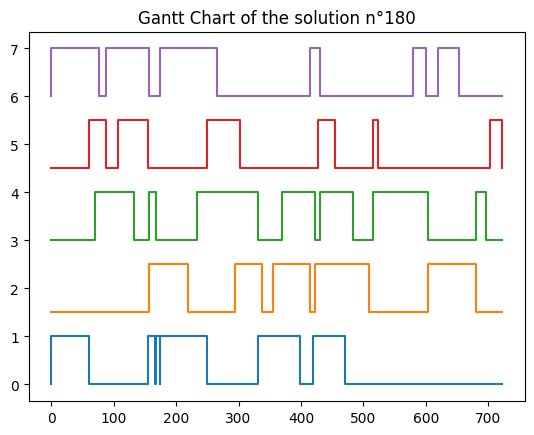

Makespan of the solution n°180 : 722
Regularity of the solution n°180 : 3412
Objective function of the solution n°180 : 2463464


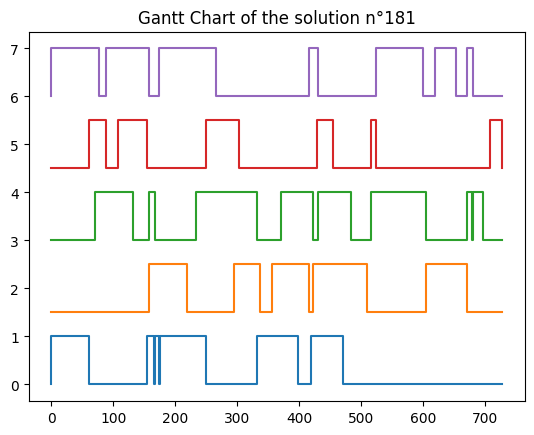

Makespan of the solution n°181 : 727
Regularity of the solution n°181 : 3396
Objective function of the solution n°181 : 2468892


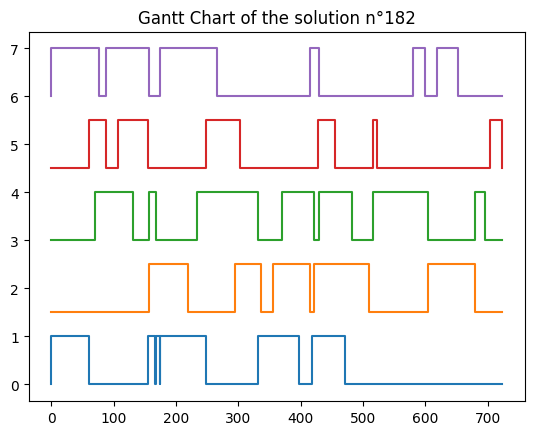

Makespan of the solution n°182 : 723
Regularity of the solution n°182 : 3416
Objective function of the solution n°182 : 2469768


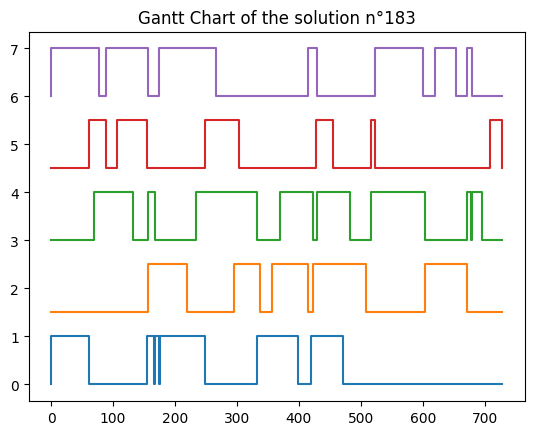

Makespan of the solution n°183 : 728
Regularity of the solution n°183 : 3400
Objective function of the solution n°183 : 2475200


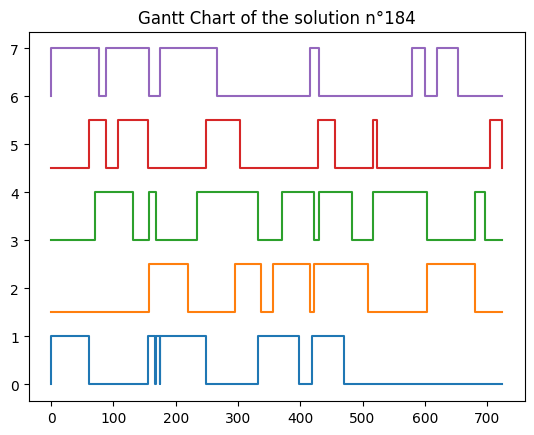

Makespan of the solution n°184 : 724
Regularity of the solution n°184 : 3420
Objective function of the solution n°184 : 2476080


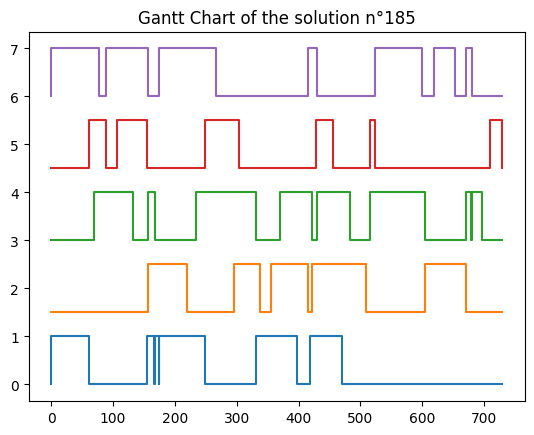

Makespan of the solution n°185 : 729
Regularity of the solution n°185 : 3404
Objective function of the solution n°185 : 2481516


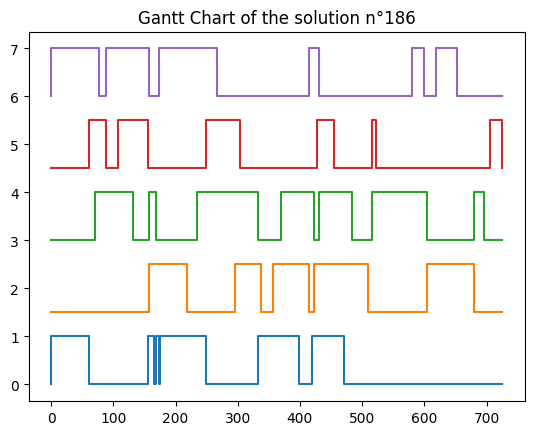

Makespan of the solution n°186 : 725
Regularity of the solution n°186 : 3424
Objective function of the solution n°186 : 2482400


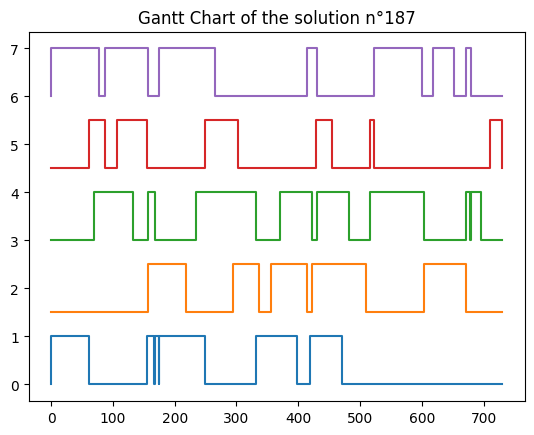

Makespan of the solution n°187 : 730
Regularity of the solution n°187 : 3408
Objective function of the solution n°187 : 2487840


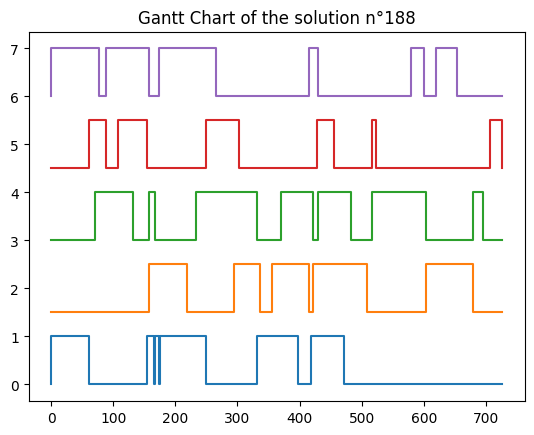

Makespan of the solution n°188 : 726
Regularity of the solution n°188 : 3428
Objective function of the solution n°188 : 2488728


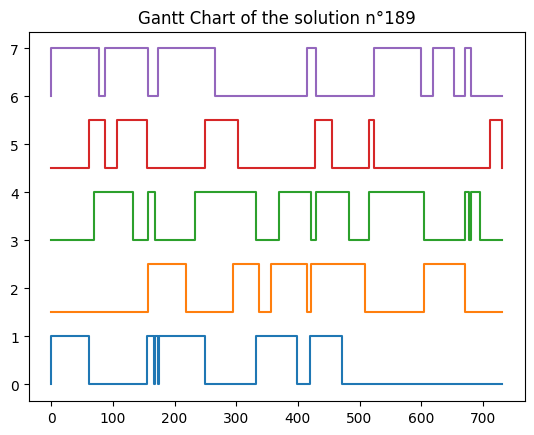

Makespan of the solution n°189 : 731
Regularity of the solution n°189 : 3412
Objective function of the solution n°189 : 2494172


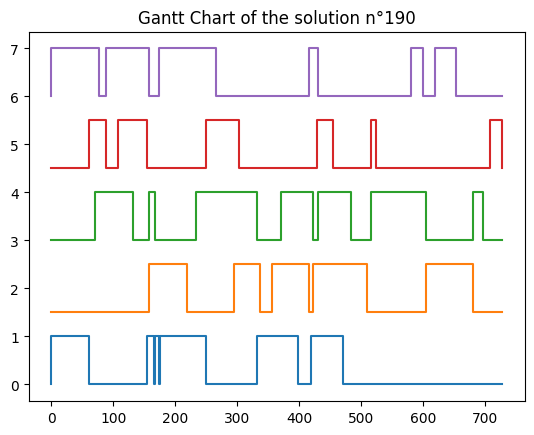

Makespan of the solution n°190 : 727
Regularity of the solution n°190 : 3432
Objective function of the solution n°190 : 2495064


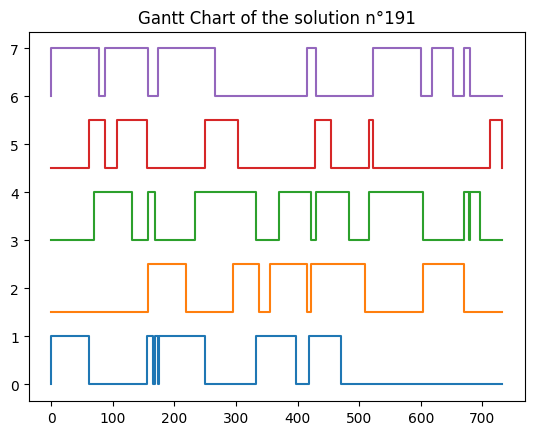

Makespan of the solution n°191 : 732
Regularity of the solution n°191 : 3416
Objective function of the solution n°191 : 2500512


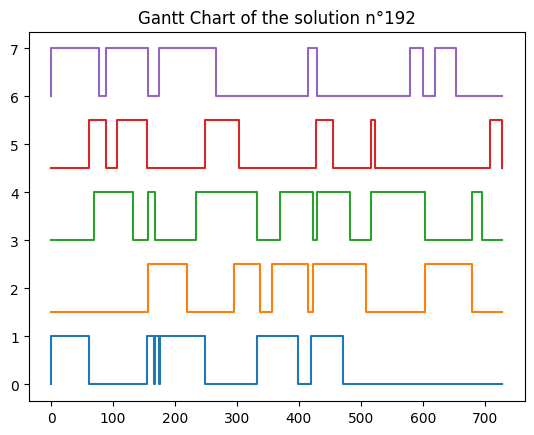

Makespan of the solution n°192 : 728
Regularity of the solution n°192 : 3436
Objective function of the solution n°192 : 2501408


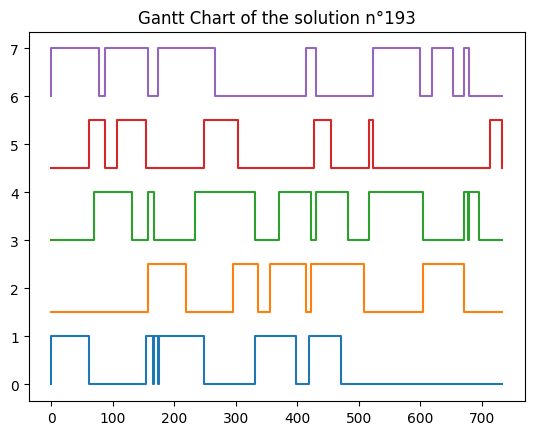

Makespan of the solution n°193 : 733
Regularity of the solution n°193 : 3420
Objective function of the solution n°193 : 2506860


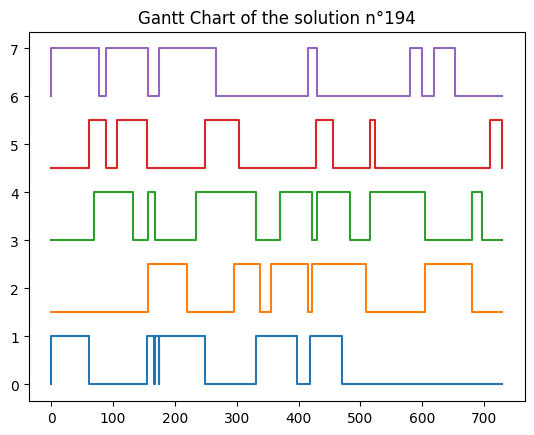

Makespan of the solution n°194 : 729
Regularity of the solution n°194 : 3440
Objective function of the solution n°194 : 2507760


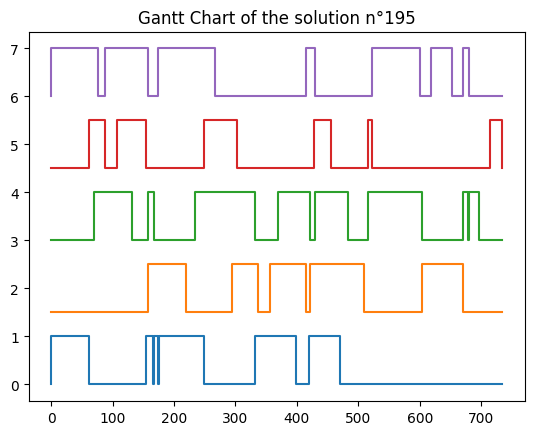

Makespan of the solution n°195 : 734
Regularity of the solution n°195 : 3424
Objective function of the solution n°195 : 2513216


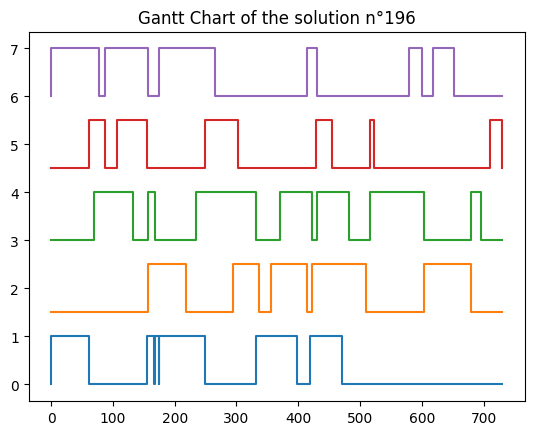

Makespan of the solution n°196 : 730
Regularity of the solution n°196 : 3444
Objective function of the solution n°196 : 2514120


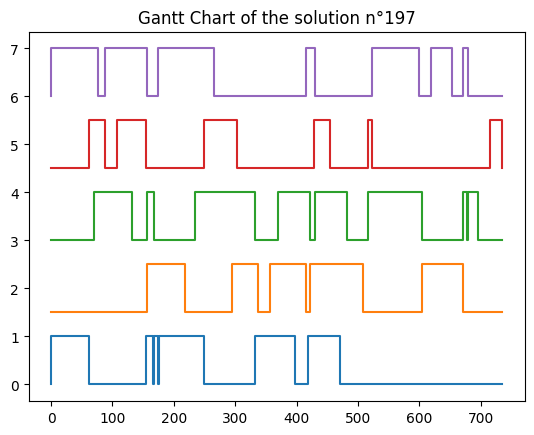

Makespan of the solution n°197 : 735
Regularity of the solution n°197 : 3428
Objective function of the solution n°197 : 2519580


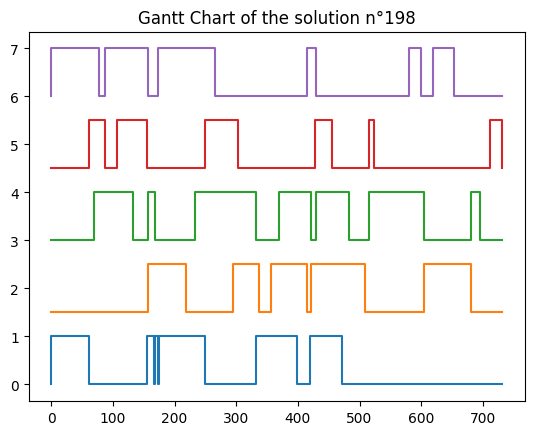

Makespan of the solution n°198 : 731
Regularity of the solution n°198 : 3448
Objective function of the solution n°198 : 2520488


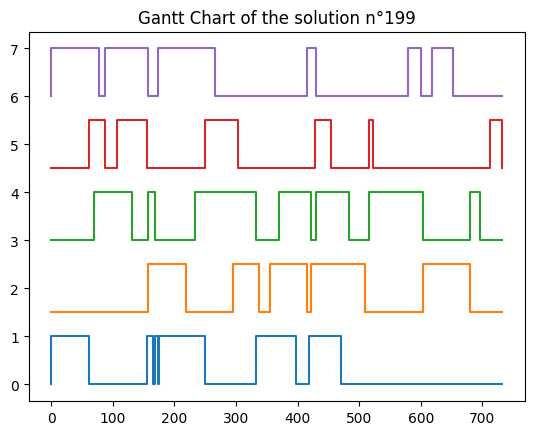

Makespan of the solution n°199 : 732
Regularity of the solution n°199 : 3452
Objective function of the solution n°199 : 2526864


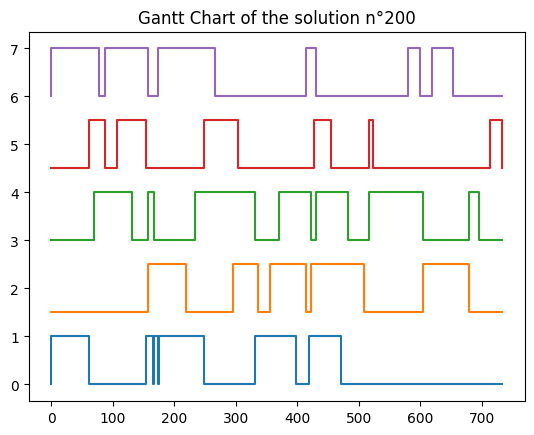

Makespan of the solution n°200 : 733
Regularity of the solution n°200 : 3456
Objective function of the solution n°200 : 2533248


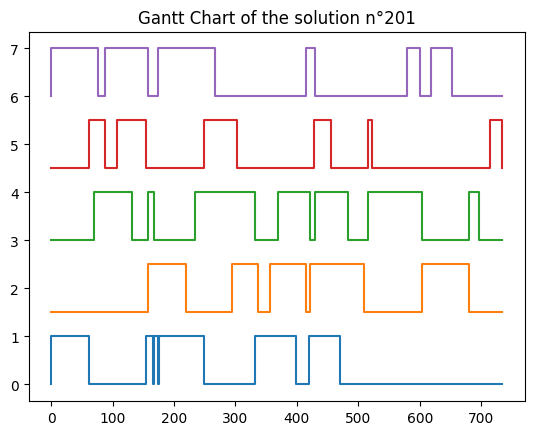

Makespan of the solution n°201 : 734
Regularity of the solution n°201 : 3460
Objective function of the solution n°201 : 2539640


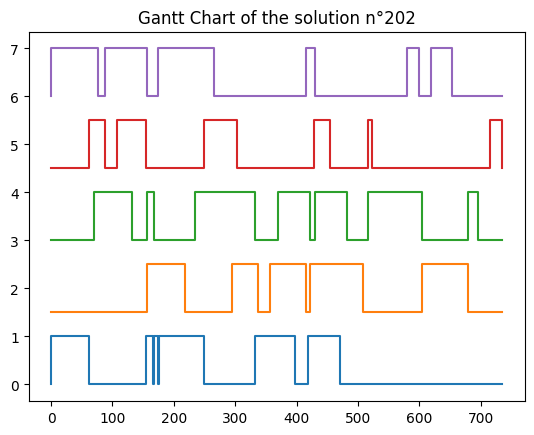

Makespan of the solution n°202 : 735
Regularity of the solution n°202 : 3464
Objective function of the solution n°202 : 2546040


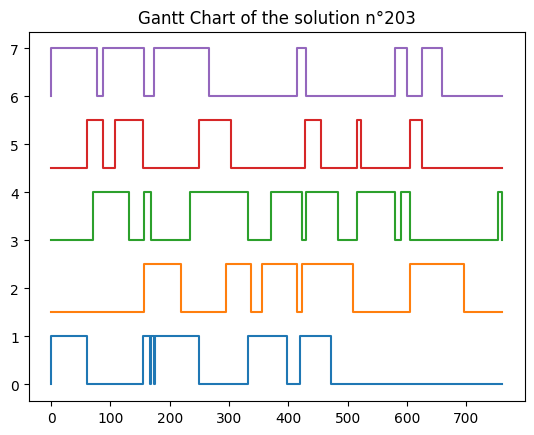

Makespan of the solution n°203 : 760
Regularity of the solution n°203 : 3452
Objective function of the solution n°203 : 2623520


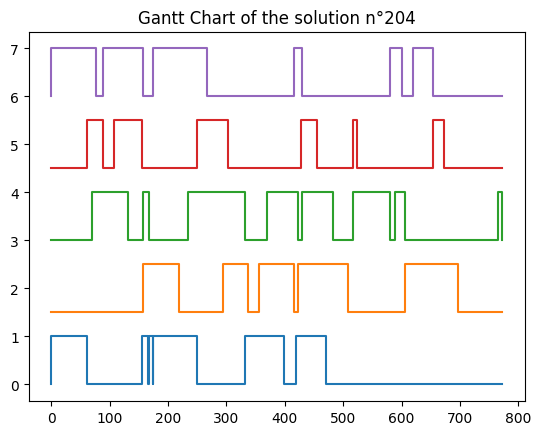

Makespan of the solution n°204 : 772
Regularity of the solution n°204 : 3556
Objective function of the solution n°204 : 2745232


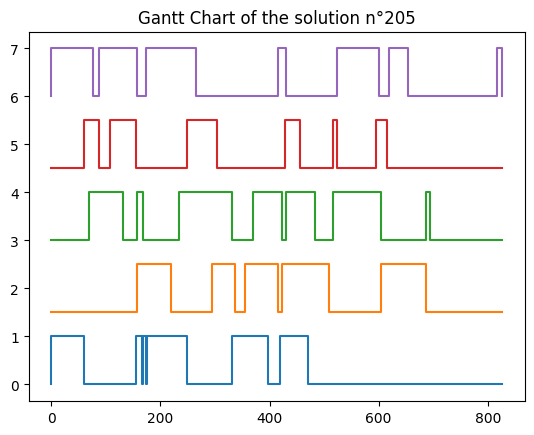

Makespan of the solution n°205 : 826
Regularity of the solution n°205 : 3488
Objective function of the solution n°205 : 2881088


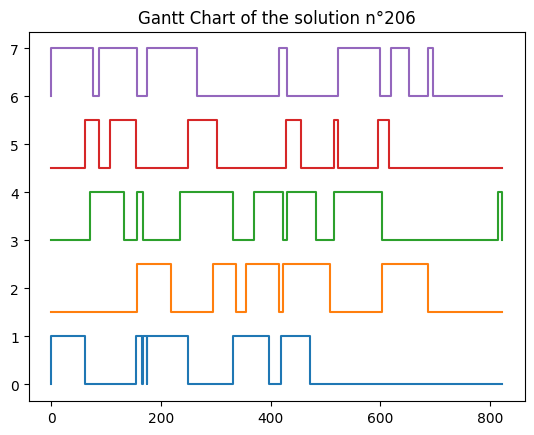

Makespan of the solution n°206 : 822
Regularity of the solution n°206 : 3676
Objective function of the solution n°206 : 3021672


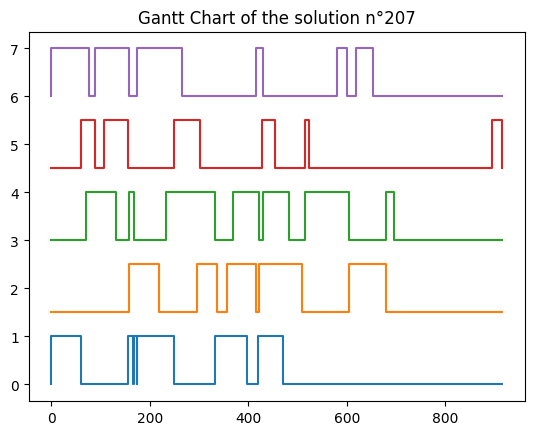

Makespan of the solution n°207 : 915
Regularity of the solution n°207 : 4184
Objective function of the solution n°207 : 3828360


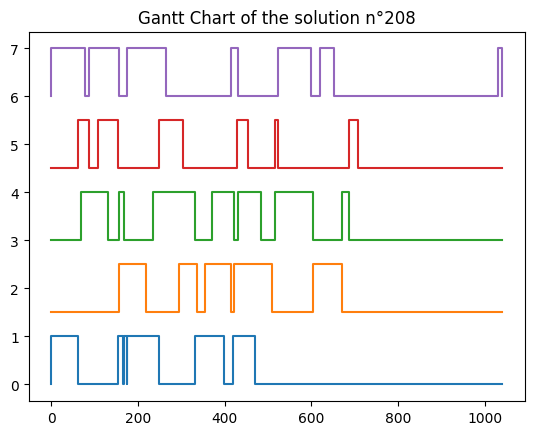

Makespan of the solution n°208 : 1040
Regularity of the solution n°208 : 4496
Objective function of the solution n°208 : 4675840


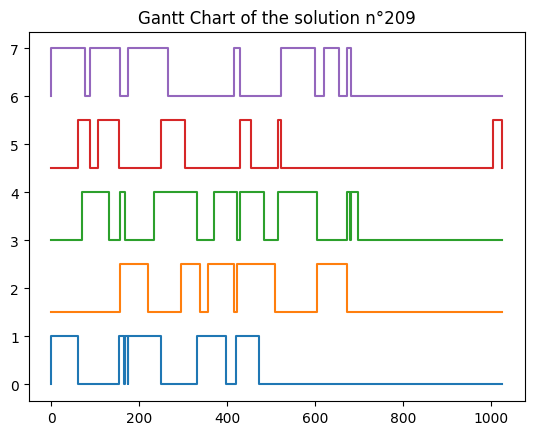

Makespan of the solution n°209 : 1024
Regularity of the solution n°209 : 4584
Objective function of the solution n°209 : 4694016


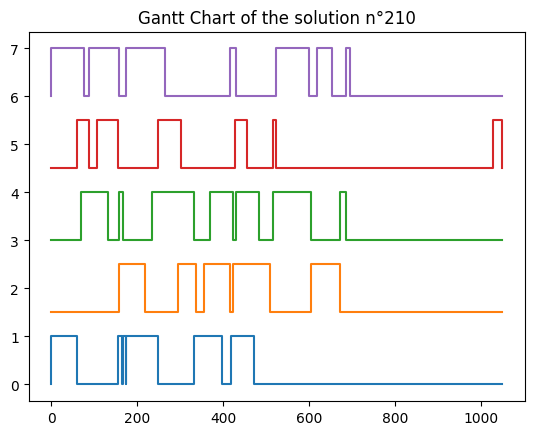

Makespan of the solution n°210 : 1049
Regularity of the solution n°210 : 4684
Objective function of the solution n°210 : 4913516


In [8]:
pref = user.getPreferences()
print(len(pref))

# ------------ Generate Gantt Chart
start_times = []
end_times = []
task_lengths = []

n_sol = 0
for sol in pref:
    n_sol = n_sol + 1
    sol_list = sol.get_all_var_solutions()
    
    mkspan=max([sol_list[i].get_end() for i in range(len(sol_list))] )
    x = [ [] for i in range(m)]
    y = [ [] for i in range(m)]
    mp = [ {} for i in range(m)]
    sz=len(sol_list)
    for i in range(sz) : 
        ind=T_machine[i]
        x[ind].append(sol_list[i].get_start())
        mp[ind][sol_list[i].get_start()]=ind
        x[ind].append(sol_list[i].get_end())
        mp[ind][sol_list[i].get_end()]=ind+1
    eps=0.5
    for i in range(m):
        x[i]=sorted(x[i])
        y[i]=[mp[i][x[i][j]]+i*eps for j in range(len(x[i]))]
        x[i]=[0]+x[i]
        y[i]=[i+i*eps]+y[i]
        x[i]=x[i]+[mkspan]
        y[i].append(i+i*eps)
        plt.step(x[i],y[i])
    plt.title("Gantt Chart of the solution n°" + str(n_sol))
    plt.show()
    print("Makespan of the solution n°" + str(n_sol) + " : " + str(mkspan))
    print("Regularity of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunctionRegularity(sol, n, m)))
    print("Objective function of the solution n°" + str(n_sol) + " : " + str(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m)))